# This script calculates both the suitability change risk and the risk from two extreme events as a demonstration of how this could be done

# Agroforestry Exposure Builder

This following cell builds **exposure datasets** for agroforestry system modelling from Excel input files.

## Workflow

1. **Import utilities**  
   - Adds the parent directory to `sys.path` so `config.py` and other shared modules can be found.  
   - Imports functions from `utils_agroforestry.py` (e.g. `get_target_species`, `build_exposures_from_file`).  

2. **Load input Excel files**  
   - Looks for all `.xlsx` files inside the `agroforestry_systems/` directory (relative to the notebook/script location).  
   - Each file represents one agroforestry system definition.  

3. **Standardise species names**  
   - Uses a mapping (`species_replacements`) to replace generic entries like `"Inga spp."` with target species such as `"Inga vera"`.  

4. **Build target species list**  
   - Extracts a global list of all relevant species across the input files.  

5. **Generate exposures**  
   - For each Excel file, calls `build_exposures_from_file` to construct an exposure object aligned to the global target species.  
   - Stores all exposures in a dictionary (`exposures_all`) keyed by system name.  





In [1]:
from pathlib import Path
import sys

# --- Use cwd when __file__ isn't available (Jupyter/IPython) ---
this_dir = Path().resolve()        # current working directory
parent_dir = this_dir.parent
sys.path.insert(0, str(parent_dir))

# ✅ Now this works
from utils_agroforestry import *


In [14]:
from pathlib import Path

# --- Paths for Excel files ---
notebook_dir = Path().resolve()
excel_dir =  parent_dir / "agroforestry_systems"
excel_files = sorted(excel_dir.glob("*.xlsx"))

# --- Species replacements ---
species_replacements = {
    "Inga spp.": "Inga vera",
    "Citrus spp.": "Citrus sinensis",
    "Quercus spp.": "Quercus sapotifolia",
    "Musa spp.": "Musa acuminata",
    "Chamedorea spp.": "Chamedorea tepejilote",
}

# --- Build global target list ---
target_species = get_target_species(excel_files, species_replacements)

# --- Build exposures for all files ---
exposures_all = {}
for file_path in excel_files:
    parts = file_path.stem.split("__")
    key = "__".join(parts[1:]) if len(parts) >= 3 else file_path.stem
    exposures_all[key] = build_exposures_from_file(
        file_path, target_species, species_replacements
    )

print(f"✅ Created exposures for {len(exposures_all)} files.")


✅ Created exposures for 5 files.


### let's limit a bit the number of alternatives

In [15]:
def filter_exposures(exposures_all):
    """Keep only selected alternatives for each system."""
    keep = {"present", "shade_-20", "shade_+20", "coffee_to_cacao", "cacao_to_coffee"}
    filtered = {}
    for system, alt_dict in exposures_all.items():
        filtered[system] = {k: v for k, v in alt_dict.items() if k in keep}
    return filtered

# ✅ Apply filter
exposures = filter_exposures(exposures_all)

# load impact functions

when we trained the suitability models, we got thresholds for each species that optimise the preformance of the model to have as many false postives as false negatives. We use those threshold, so for instance if the threshold is 0.2, below 0.2 suitability the impact is 100 percent

In [4]:
# Standard assumed densities for main crops in agroforestry systems (trees/ha)
MAIN_CROP_DENSITIES = {
    "Coffea arabica": 1800,   # Coffee (agroforestry average)
    "Theobroma cacao": 1100,  # Cacao (agroforestry average)
}

# Loop through all systems and alternatives
for system_name, alternatives in exposures.items():
    for alt_name, exp in alternatives.items():
        gdf = exp.gdf

        for sci_name, std_density in MAIN_CROP_DENSITIES.items():
            mask = gdf["Scientific name"].str.lower() == sci_name.lower()
            if mask.any():
                gdf.loc[mask, "Plants/ha"] = std_density
                gdf.loc[mask, "value"] = std_density
                print(f"🌱 Set {sci_name} density = {std_density} "
                      f"for {system_name} – {alt_name} ({mask.sum()} rows)")


🌱 Set Theobroma cacao density = 1100 for Cacao__AltaVerapaz – present (10 rows)
🌱 Set Theobroma cacao density = 1100 for Cacao__AltaVerapaz – shade_-20 (10 rows)
🌱 Set Theobroma cacao density = 1100 for Cacao__AltaVerapaz – shade_+20 (10 rows)
🌱 Set Coffea arabica density = 1800 for Cacao__AltaVerapaz – cacao_to_coffee (10 rows)
🌱 Set Theobroma cacao density = 1100 for Cacao__DR_Cibao_Noroeste – present (10 rows)
🌱 Set Theobroma cacao density = 1100 for Cacao__DR_Cibao_Noroeste – shade_-20 (10 rows)
🌱 Set Theobroma cacao density = 1100 for Cacao__DR_Cibao_Noroeste – shade_+20 (10 rows)
🌱 Set Coffea arabica density = 1800 for Cacao__DR_Cibao_Noroeste – cacao_to_coffee (10 rows)
🌱 Set Coffea arabica density = 1800 for Coffee__DR_Cibao_Noroeste – present (10 rows)
🌱 Set Coffea arabica density = 1800 for Coffee__DR_Cibao_Noroeste – shade_-20 (10 rows)
🌱 Set Coffea arabica density = 1800 for Coffee__DR_Cibao_Noroeste – shade_+20 (10 rows)
🌱 Set Theobroma cacao density = 1100 for Coffee__DR_

In [5]:
import numpy as np
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

# Build the set
impf_set = ImpactFuncSet()
for species in target_species:
    impf_set.append(make_threshold_impf(species, impf_id=2, zero=False))  # real (thresholded)
    impf_set.append(make_threshold_impf(species, impf_id=1, zero=True))   # dummy (always 0)


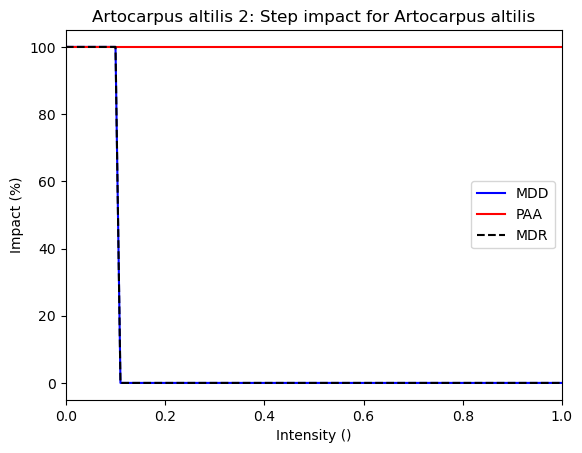

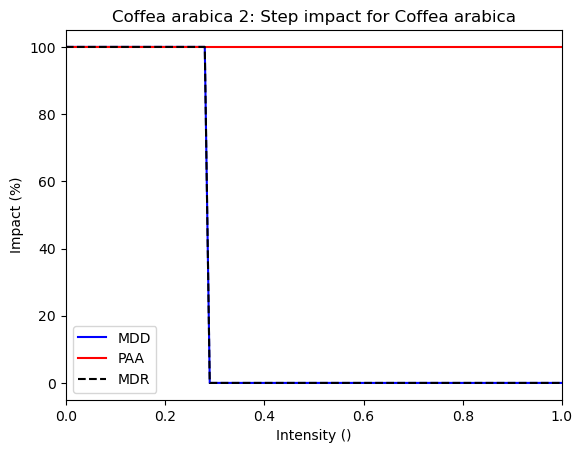

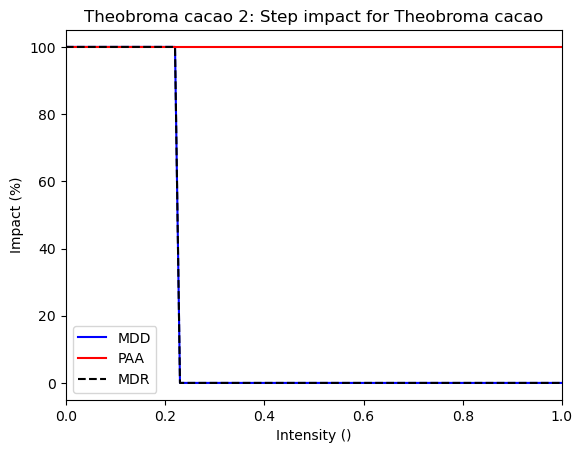

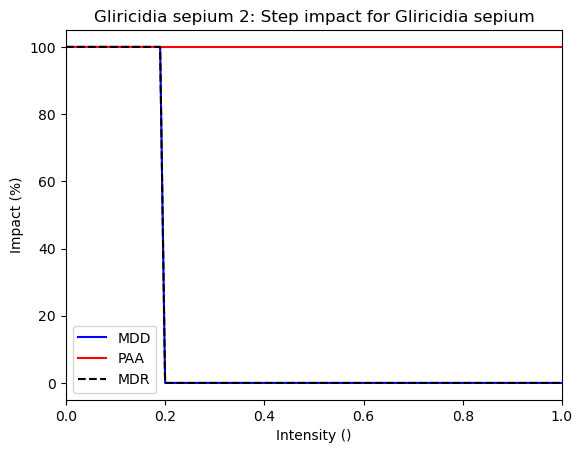

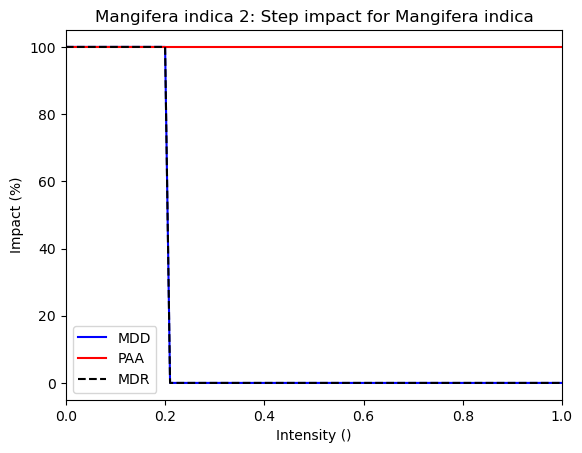

In [6]:
species_list = [
    "Artocarpus altilis",
    "Coffea arabica",
    "Theobroma cacao",
    "Gliricidia sepium",
    "Mangifera indica"
]
for s in species_list:
    impf_set.get_func()[s][2].plot()


# Suitability Maps as Hazard Objects

This script converts species suitability maps into **CLIMADA Hazard objects**.  
The purpose is to represent species suitability (under current and future climate conditions) in the same format that CLIMADA normally uses for hazards (e.g. floods, cyclones, heatwaves).  
This allows us to combine suitability with **exposures** and **impact functions** in a consistent modelling workflow.  

---

## 📘 Workflow

### 1. Load suitability maps
- Function `load_suitability_dict(label)` loads `.parquet` files of suitability values for each species.  

- Each parquet file contains:
- `lon`, `lat`: grid coordinates  
- `suitability`: suitability score for that species at that location  

The function returns a dictionary:
```python
{"Coffea arabica": DataFrame, "Inga vera": DataFrame, ...}
````

### 2. Rebuild spatial grid

* For each species, longitude and latitude are extracted and converted into a 2D grid.
* Suitability values are mapped into this grid (`Z_mean`).
* Missing locations are left as `NaN`.

### 3. Wrap as Hazard

* Suitability is stored in a CLIMADA `Hazard` object using `Hazard.from_xarray_raster`.
* Dimensions:

  * **event**: fixed to a single dummy event (`0`), since suitability is not time-varying.
  * **latitude, longitude**: spatial grid.
  * **time**: dummy timestamp (`2000-01-01`).

⚠️ **Important:**

* A typical hazard (e.g. a flood) has **many events** across time and space.
* These suitability hazards have **only one event**: the static mean suitability under a given climate condition (`now`, `future`, or `4c`).

Each hazard is named like:

```
species_label  →  e.g. "Coffea arabica_now", "Inga vera_future"
```

### 4. Store hazards

* Hazards are stored in a dictionary structure:

```python
hazards = {
  "now": {"Coffea arabica": Hazard, "Inga vera": Hazard, ...},
  "future": {...}
}
```

Species without suitability maps in both **now** and **future** are skipped (listed at the end).

---

## ▶️ Example Output

```text
✅ Created suitability mean Hazard objects.
⚠️ Skipped 2 species (no suitability file):
   - Citrus sinensis
   - Musa acuminata
```

---

## 🌳 How this fits in the pipeline

```text
Suitability map (static scores)
        ↓
Converted to Hazard object (1 dummy event)
        ↓
Exposures (plots, species composition)
        ↓
Dummy Impact Functions (just a matching tool)
        ↓
CLIMADA Impact calculation
```

* Here, suitability plays the role of the "hazard intensity".
* Exposures are the agroforestry plots and their species.
* Dummy impact functions simply act as a bridge, ensuring the species in exposures can be linked with the suitability hazard.

---



In [7]:
from utils_hazards import *
import glob

In [8]:
files = glob.glob(str(DATA_DIR / "suitability" / "*.parquet"))

# --- keep function unchanged ---
hazards = load_suitability_hazards(files, sample=False)



# Suitability Impact Calculation

This script calculates **species-specific suitability scores** for multiple systems based on exposure, hazard, and impact modelling with [CLIMADA](https://climada-python.readthedocs.io/). It loops over available systems and species, evaluates current and future suitability, and stores the results in a structured dictionary of `GeoDataFrame`s.

---

## 📂 Workflow

1. **Inputs**
   - `exposures_present`: dictionary of `Exposures` objects, one per system.
   - `hazards`: dictionary containing hazard objects for `"now"` and `"future"` scenarios, keyed by species.
   - `impf_set`: impact function set compatible with the exposures and hazards.
   - `skipped_species`: list of species to ignore (e.g. missing hazard data).

2. **Processing**
   - For each system in `exposures_present`:
     - Iterate over all species present in the system.
     - Skip species listed in `skipped_species`.
     - Extract hazards (`now` and `future`) for that species.
     - Run CLIMADA `Impact` calculations for both hazard periods.
     - Derive suitability as:

       ```
       suitability = 1 - eai_exp
       ```

       where `eai_exp` is the expected annual impact from CLIMADA.
     - Append results into a per-system list.

3. **Outputs**
   - Results for each system are concatenated into a single `GeoDataFrame` containing:
     - All exposure geometry and attributes,
     - Suitability under `now` and `future` climate scenarios.
   - Stored in a dictionary:

     ```python
     system_results[system_name] = GeoDataFrame(...)
     ```

4. **Final message**
   - The script prints how many systems were successfully processed.

---

## 📑 Data structure of output

Each system’s results are stored as a `GeoDataFrame` with at least the following columns:

- `species_clean`: Original species name from exposures.
- `suitability_now`: Suitability score under current hazard data (0–1).
- `suitability_future`: Suitability score under future hazard data (0–1).
- Additional attributes from the exposure input (location, system metadata, etc.).

---

## ▶️ Example usage

```python
# Example: access results for one system
results = system_results["System_A"]

# Check first rows
print(results.head())

# Plot suitability for current climate
results.plot(column="suitability_now", legend=True)


In [9]:
import pandas as pd
from geopandas import GeoDataFrame
from climada.engine import Impact
from climada.entity import Exposures

# Dictionary to store results per system + alternative
system_results = {}

for system_name, alternatives in exposures.items():
    print(f"📂 Processing system: {system_name}")
    system_results[system_name] = {}

    for alt_name, exp_system in alternatives.items():
        print(f"  🔀 Alternative: {alt_name}")
        results_list = []

        for species in exp_system.gdf.species_clean.unique():
            # 🔹 Only keep rows for this species
            exp_species = exp_system.gdf[exp_system.gdf.species_clean == species].copy()
            exp_species["value"] = exp_species["Plants/ha"]

            # Hazards
            haz_now = hazards["historical"][species]
            haz_future2 = hazards["2c"][species]
            haz_future4 = hazards["4c"][species]

            haz_now.check()
            haz_future2.check()
            haz_future4.check()

            # Impacts
            imp_now = Impact(); imp_now.calc(Exposures(exp_species), impf_set, haz_now)
            imp_2c  = Impact(); imp_2c.calc(Exposures(exp_species), impf_set, haz_future2)
            imp_4c  = Impact(); imp_4c.calc(Exposures(exp_species), impf_set, haz_future4)

            # Build results frame
            df = exp_species.copy()
            df["species_eval"] = species
            df["impact_now"] = imp_now.eai_exp
            df["impact_2c"]  = imp_2c.eai_exp
            df["impact_4c"]  = imp_4c.eai_exp

            # --- Normalise to per-tree loss ---
            df["frac_loss_now"] = df["impact_now"] / df["Plants/ha"]
            df["frac_loss_2c"]  = df["impact_2c"]  / df["Plants/ha"]
            df["frac_loss_4c"]  = df["impact_4c"]  / df["Plants/ha"]


            results_list.append(df)

        if results_list:
            results_all = pd.concat(results_list, ignore_index=True)
            system_results[system_name][alt_name] = GeoDataFrame(
                results_all, crs=exp_system.gdf.crs
            )
        else:
            print(f"  ⚠️ No results for {system_name} – {alt_name} (all species skipped)")

print(f"✅ Created suitability results for {sum(len(v) for v in system_results.values())} system-alternatives.")


📂 Processing system: Cacao__AltaVerapaz
  🔀 Alternative: present
2025-08-29 10:53:47,337 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-08-29 10:53:47,409 - climada.hazard.base - WARNING - Impact function id=2 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-08-29 10:53:47,412 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-08-29 10:53:47,486 - climada.hazard.base - WARNING - Impact function id=2 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
2025-08-29 10:53:47,488 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2025-08-29 10:53:47,556 - climada.hazard.base - WARNING - Impact function id=2 has mdr

## Gain-aware optimisation (`present_optimised`)

This routine builds a new **`present_optimised`** alternative by reallocating shade-tree density:

1. Compute climate-driven change (`delta_2c = impact_2c - impact_now`).
2. Identify **worst** and **best** shade species (depending on whether all improve, all worsen, or mixed).
3. Shift **50% of trees** from worst → best species.
4. Recalculate impacts (`impact_now`, `impact_2c`, `impact_4c`) and suitability.
5. Save to `system_results[system_name]["present_optimised"]` and `exposures[...]`.

📌 This is a heuristic test: it doesn’t change crop trees, only shade species, and assumes proportional reallocation.


In [10]:
import numpy as np
from geopandas import GeoDataFrame
from climada.entity import Exposures

MAIN_CROPS = ["Coffea arabica", "Theobroma cacao"]

# --- Add "present_optimised" alternatives (gain-aware) ---
for system_name, alternatives in system_results.items():
    if "present" not in alternatives:
        continue

    gdf = alternatives["present"].copy()

    # --- Compute changes from baseline ---
    gdf["delta_2c"] = gdf["impact_2c"] - gdf["impact_now"]

    # Only consider shade species
    shade = gdf[~gdf["Scientific name"].isin(MAIN_CROPS)]

    if shade.empty:
        continue

    # Identify best/worst species depending on context
    if (shade["delta_2c"] >= 0).all():  
        # All improving → optimise gains
        worst_species = shade.groupby("Species")["delta_2c"].mean().idxmin()
        best_species  = shade.groupby("Species")["delta_2c"].mean().idxmax()
    elif (shade["delta_2c"] <= 0).all():  
        # All losing → mitigate losses
        worst_species = shade.groupby("Species")["delta_2c"].mean().idxmax()
        best_species  = shade.groupby("Species")["delta_2c"].mean().idxmin()
    else:
        # Mixed case → default: reduce losses
        worst_species = shade.groupby("Species")["delta_2c"].mean().idxmax()
        best_species  = shade.groupby("Species")["delta_2c"].mean().idxmin()

    # --- Reallocate trees (half of worst → best) ---
    total_worst = gdf.loc[gdf.Species == worst_species, "Plants/ha"].sum()
    n_shift = int(total_worst * 0.5)

    if n_shift > 0:
        # Subtract from worst species (proportional)
        worst_mask = gdf.Species == worst_species
        gdf.loc[worst_mask, "Plants/ha"] -= (
            gdf.loc[worst_mask, "Plants/ha"] / total_worst * n_shift
        ).round()

        # Add to best species
        best_mask = gdf.Species == best_species
        if best_mask.any():
            total_best = gdf.loc[best_mask, "Plants/ha"].sum()
            if total_best > 0:
                gdf.loc[best_mask, "Plants/ha"] += (
                    gdf.loc[best_mask, "Plants/ha"] / total_best * n_shift
                ).round()
            else:
                gdf.loc[best_mask].iloc[0, gdf.columns.get_loc("Plants/ha")] += n_shift
        else:
            print(f"⚠️ Best species {best_species} not found in {system_name}")

    # --- 🔄 Recalculate impacts ---
    for col in ["now", "2c", "4c"]:
        gdf[f"impact_{col}"] = gdf[f"frac_loss_{col}"] * gdf["Plants/ha"]
        gdf[f"suitability_{col}"] = 1 - gdf[f"frac_loss_{col}"]

    # ✅ Save as new alternative
    system_results[system_name]["present_optimised"] = GeoDataFrame(gdf, crs=gdf.crs)
    exp_opt = Exposures(gdf.copy())
    exposures[system_name]["present_optimised"] = exp_opt

    print(f"✅ Added gain-aware 'present_optimised' for {system_name} "
          f"(worst={worst_species}, best={best_species})")

print("🎯 Done — gain-aware optimisation applied.")


✅ Added gain-aware 'present_optimised' for Cacao__AltaVerapaz (worst=Avocado, best=Inga)
✅ Added gain-aware 'present_optimised' for Cacao__DR_Cibao_Noroeste (worst=Bitter orange, best=Breadfruit)
✅ Added gain-aware 'present_optimised' for Coffee__DR_Cibao_Noroeste (worst=Sapote, best=Breadfruit)
✅ Added gain-aware 'present_optimised' for Coffee__Veracruz (worst=Cedrela odorata, best=Quercus sapotifolia)
✅ Added gain-aware 'present_optimised' for Coffee__WesternHighlands (worst=Walnut, best=Cedar)
🎯 Done — gain-aware optimisation applied.


## Shade tree composition plots

This script creates stacked bar charts of **shade-tree composition** (excluding main crops) for each system and alternative.

Steps:
1. Collect all non-crop species and assign consistent colours.  
2. Compute average density (plants/ha) per species across plots.  
3. Plot stacked bars by alternative, with species colours.  
4. Save figures to `FIGURES_DIR/shade_composition`.

📌 Notes:  
- Main crops (`Coffea arabica`, `Theobroma cacao`) are excluded.  
- Inga species are grouped in the legend as *Inga spp.*.  
- Colours are consistent across systems, using `matplotlib.tab20`.  


In [12]:
from config import *


🌳 Plotting shade tree composition for Cacao__AltaVerapaz
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/shade_composition/Cacao__AltaVerapaz_shade_composition.png


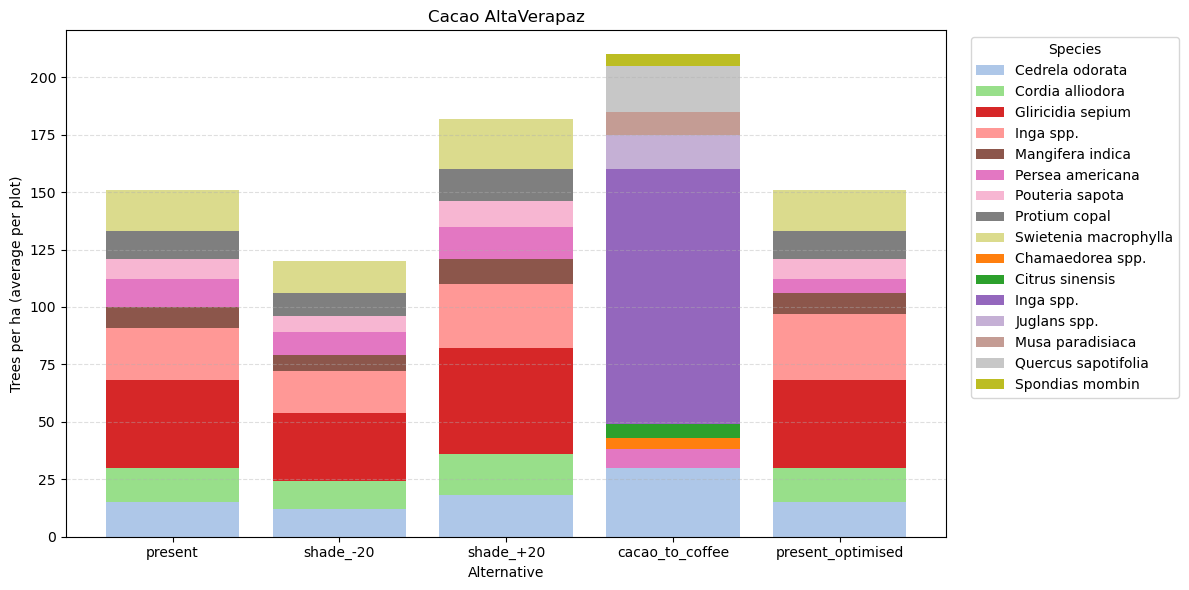

🌳 Plotting shade tree composition for Cacao__DR_Cibao_Noroeste
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/shade_composition/Cacao__DR_Cibao_Noroeste_shade_composition.png


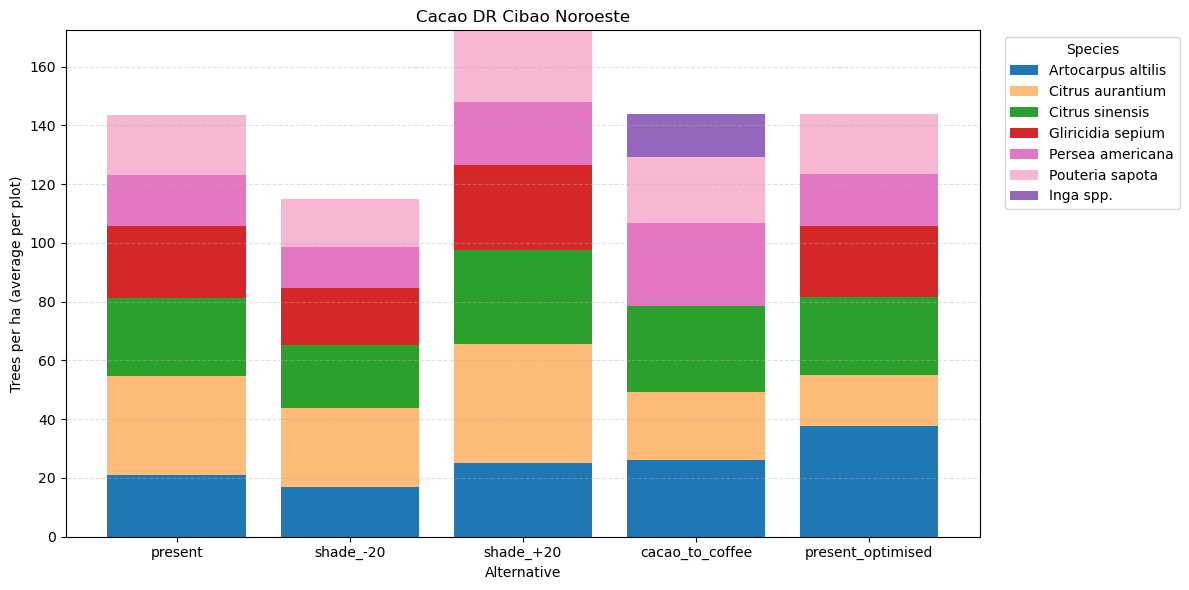

🌳 Plotting shade tree composition for Coffee__DR_Cibao_Noroeste
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/shade_composition/Coffee__DR_Cibao_Noroeste_shade_composition.png


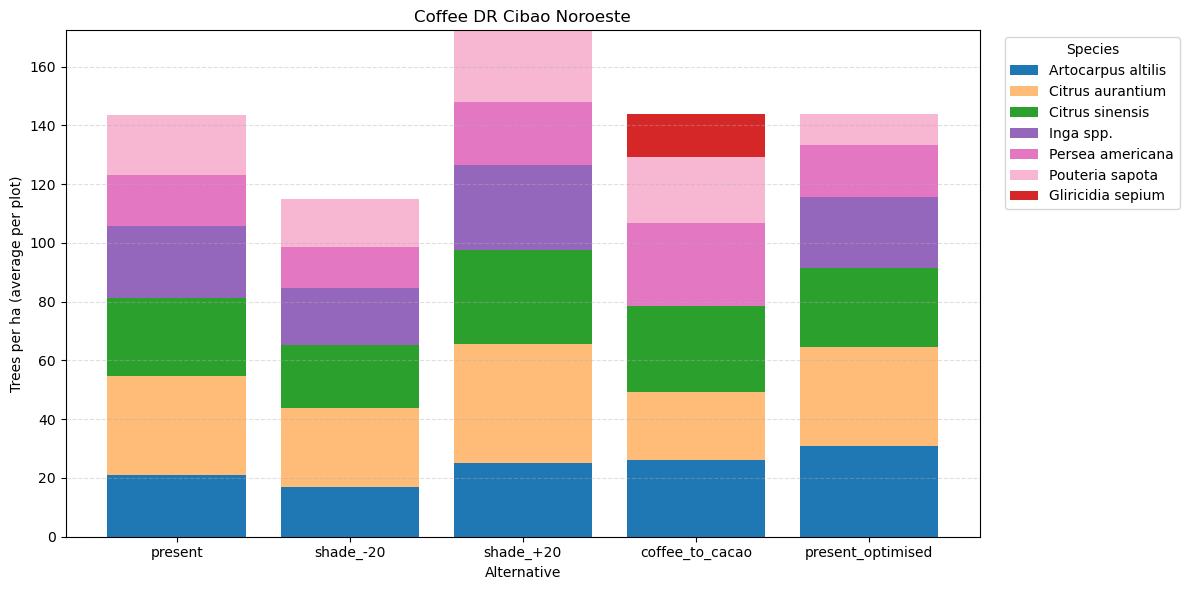

🌳 Plotting shade tree composition for Coffee__Veracruz
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/shade_composition/Coffee__Veracruz_shade_composition.png


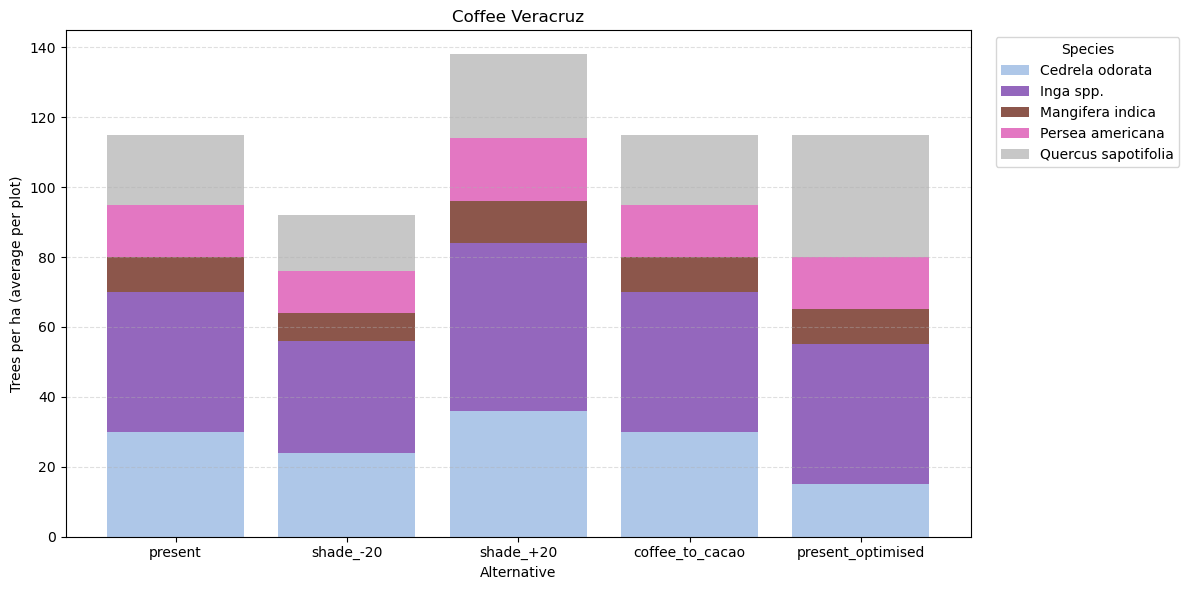

🌳 Plotting shade tree composition for Coffee__WesternHighlands
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/shade_composition/Coffee__WesternHighlands_shade_composition.png


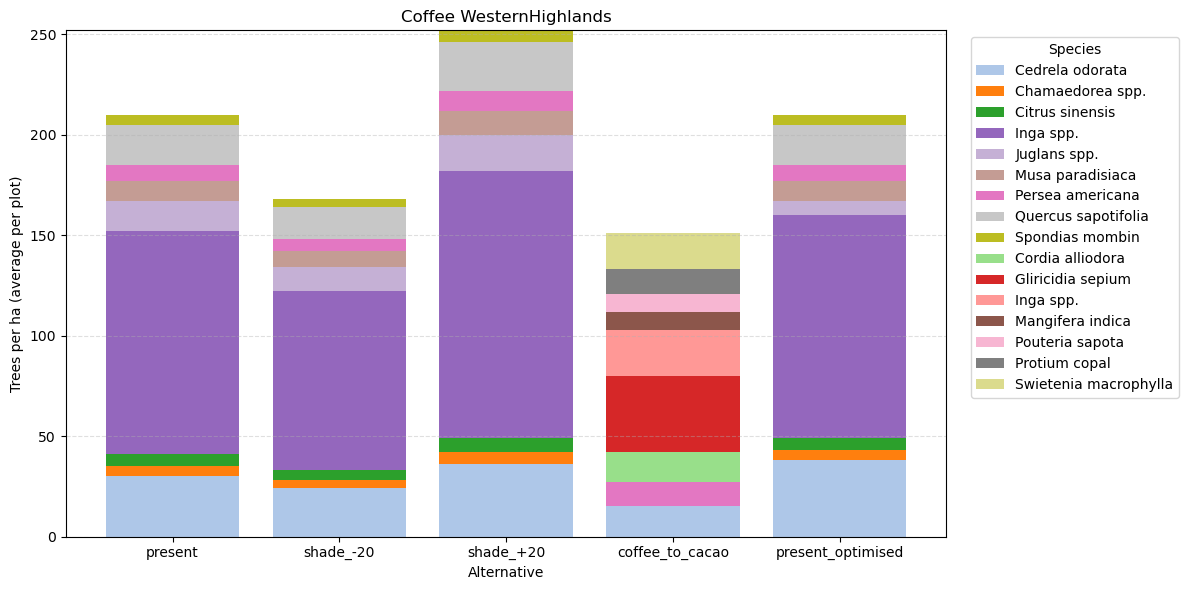

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Which species are considered "main crops"
MAIN_CROPS = {"Coffea arabica", "Theobroma cacao"}
subfolder = os.path.join(FIGURES_DIR, "shade_composition")
os.makedirs(subfolder, exist_ok=True)

# --- Build a global species color map ---
all_species = set()
for alternatives in system_results.values():
    for df in alternatives.values():
        all_species.update(df["species_clean"].unique())

# Exclude main crops from shade composition
all_species = sorted([sp for sp in all_species if sp not in MAIN_CROPS])

# Assign consistent colors
palette = plt.cm.tab20.colors  # 20 distinct colors
species_colors = {
    sp: palette[i % len(palette)] for i, sp in enumerate(all_species)
}

# Legend display mapping (only affects legend text, not data or colors)
species_display_map = {
    "Inga vera": "Inga spp.",
    "Inga sapindoides": "Inga spp."
}

# --- Plot loop ---
for system_name, alternatives in system_results.items():
    print(f"🌳 Plotting shade tree composition for {system_name}")

    comp_summary = []
    for alt_name, df in alternatives.items():
        n_plots = df["geometry"].nunique()

        # exclude main crops
        shade_df = df[~df["Scientific name"].isin(MAIN_CROPS)]

        # total per species, then average per plot
        comp = shade_df.groupby("species_clean")["Plants/ha"].sum() / n_plots
        comp_summary.append(comp.rename(alt_name))

    comp_df = pd.concat(comp_summary, axis=1).fillna(0)

    # Species & alternatives
    species = comp_df.index
    alternatives_list = comp_df.columns

    # --- Stacked bar chart ---
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(len(alternatives_list))

    for sp in species:
        vals = comp_df.loc[sp].reindex(alternatives_list, fill_value=0)
        ax.bar(alternatives_list, vals,
               bottom=bottom,
               color=species_colors[sp],
               label=sp)
        bottom += vals.values

    # Prettify title
    ax.set_title(system_name.replace("__", " ").replace("_", " "))
    ax.set_ylabel("Trees per ha (average per plot)")
    ax.set_xlabel("Alternative")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    # Only show species actually present here
    handles, labels = ax.get_legend_handles_labels()
    labels = [species_display_map.get(lbl, lbl) for lbl in labels]  # rename Inga spp.
    ax.legend(handles, labels, title="Species",
              bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()
    fname = f"{system_name}_shade_composition.png".replace(" ", "_")
    outpath = os.path.join(subfolder, fname)
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"💾 Saved: {outpath}")

    plt.show()


## Suitability impact change plots (stacked bars)

This script visualises **changes in climate impacts** (Δ impact) for shade species across alternatives:

1. Compute average impact per plot (`impact_now`, `impact_2c`, `impact_4c`) by species.  
2. Exclude main crops (`Coffea arabica`, `Theobroma cacao`).  
3. For each system and alternative, calculate **future – historical** differences.  
4. Plot stacked bar charts:  
   - Positive contributions (species gaining impact) stack upward.  
   - Negative contributions (species reducing impact) stack downward.  
5. Save results to `FIGURES_DIR/suitability_stacked_barplots_change/`.

📌 Notes:  
- Colours are consistent across systems (from `matplotlib.tab20`).  
- Inga species are grouped in the legend as *Inga spp.*.  
- Both +2 °C and +4 °C scenarios are generated for each system.  


📊 Plotting Δ impacts for Cacao__AltaVerapaz
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots_change/Cacao__AltaVerapaz_suitability_impact_change_2c.png


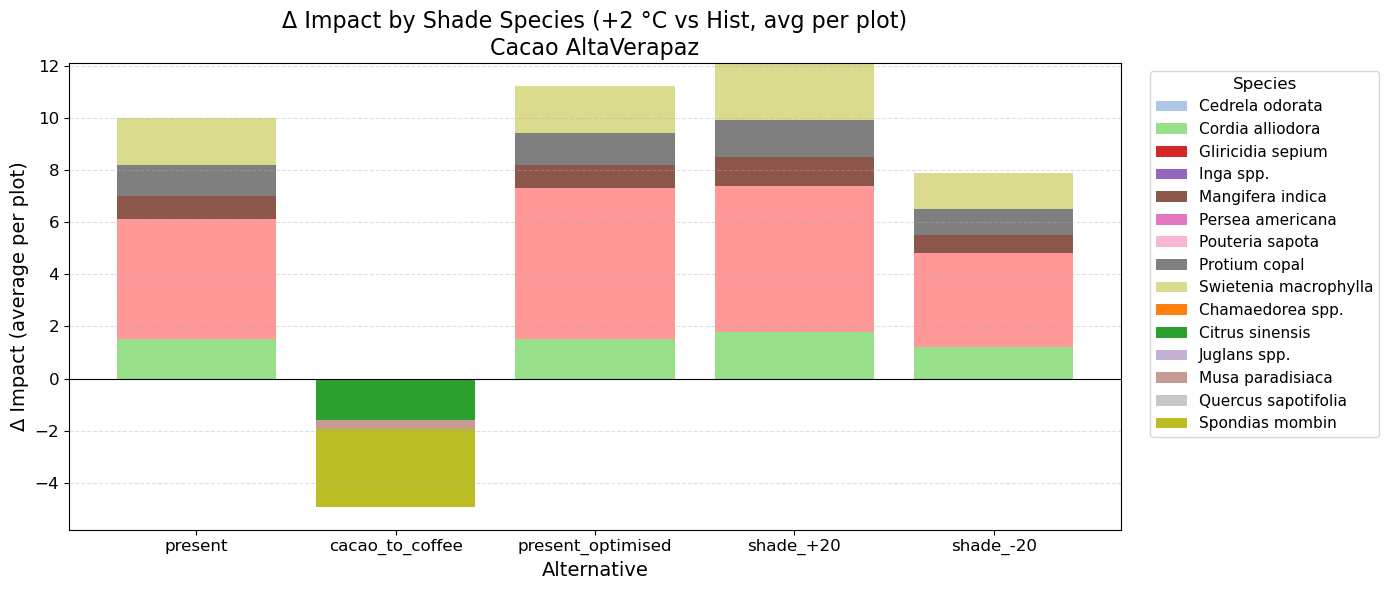

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots_change/Cacao__AltaVerapaz_suitability_impact_change_4c.png


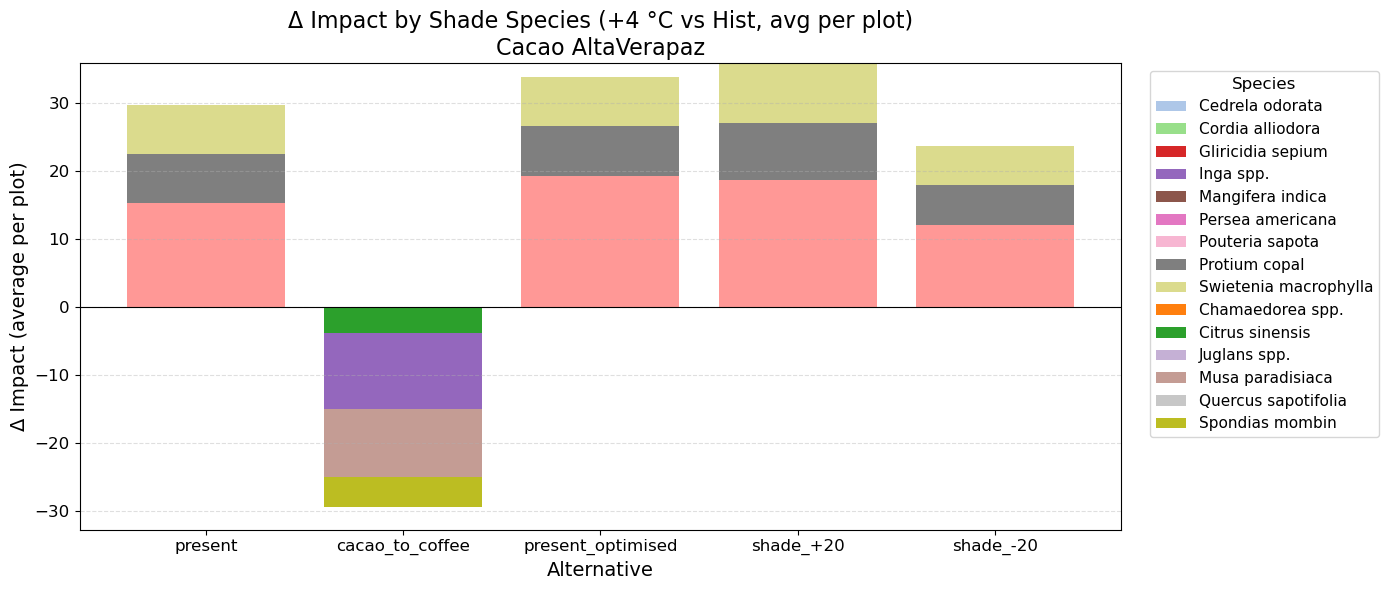

📊 Plotting Δ impacts for Cacao__DR_Cibao_Noroeste
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots_change/Cacao__DR_Cibao_Noroeste_suitability_impact_change_2c.png


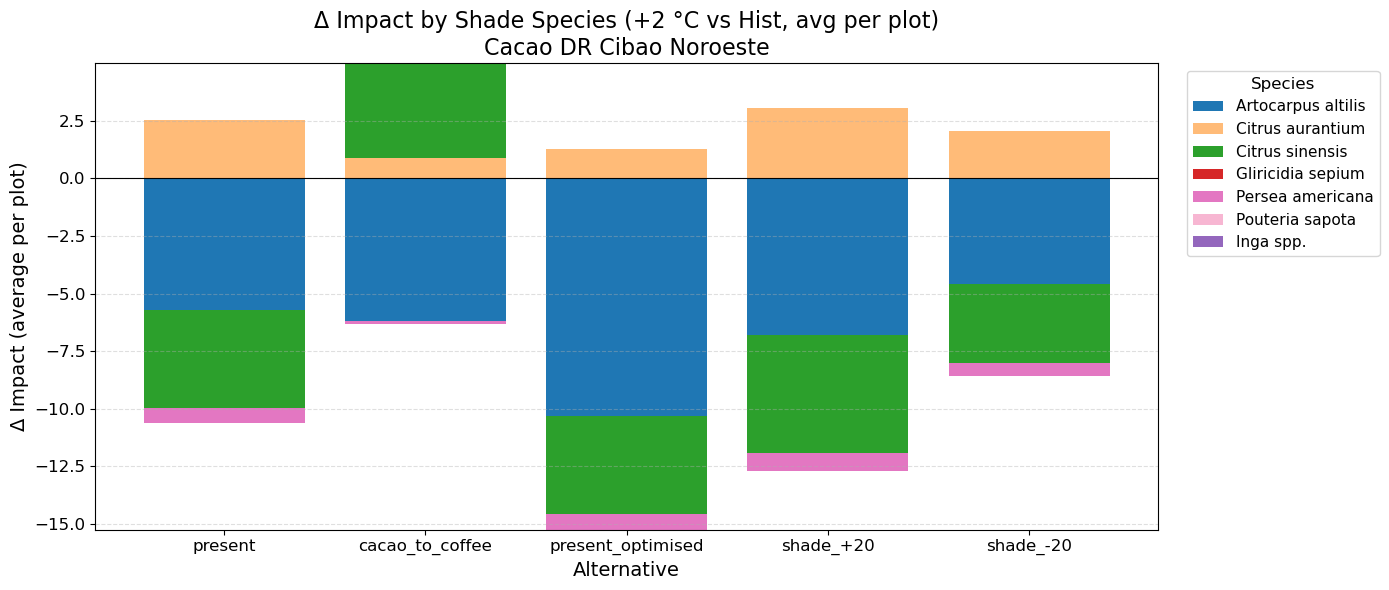

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots_change/Cacao__DR_Cibao_Noroeste_suitability_impact_change_4c.png


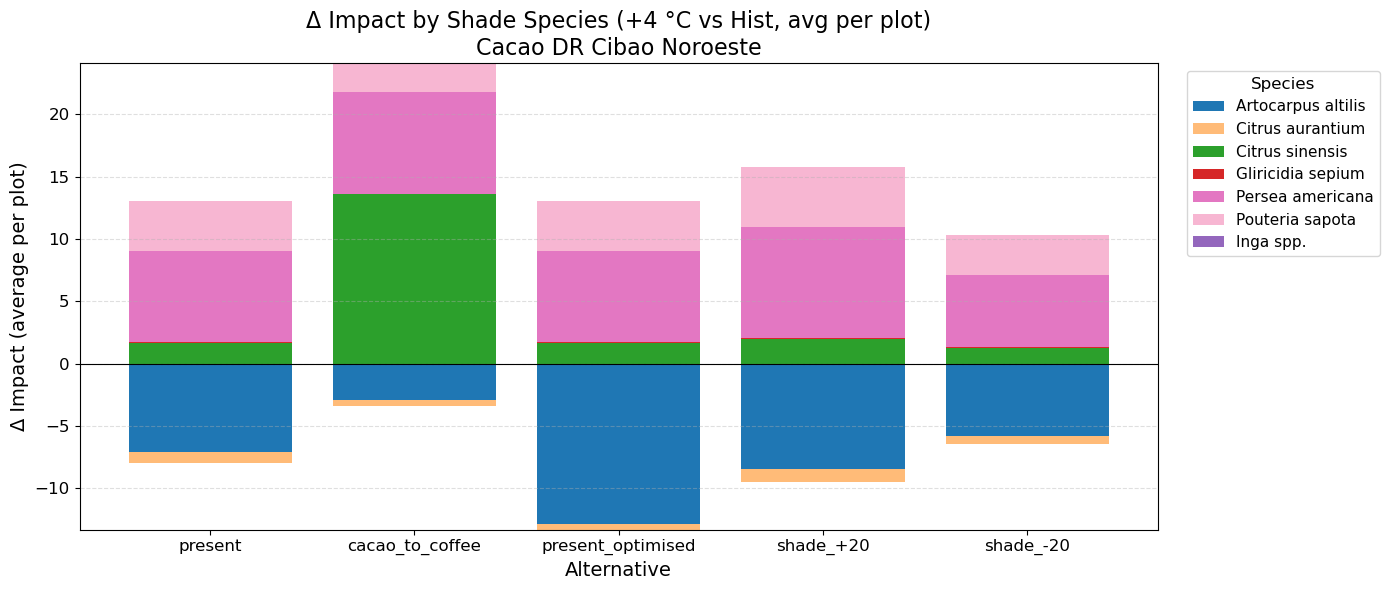

📊 Plotting Δ impacts for Coffee__DR_Cibao_Noroeste
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots_change/Coffee__DR_Cibao_Noroeste_suitability_impact_change_2c.png


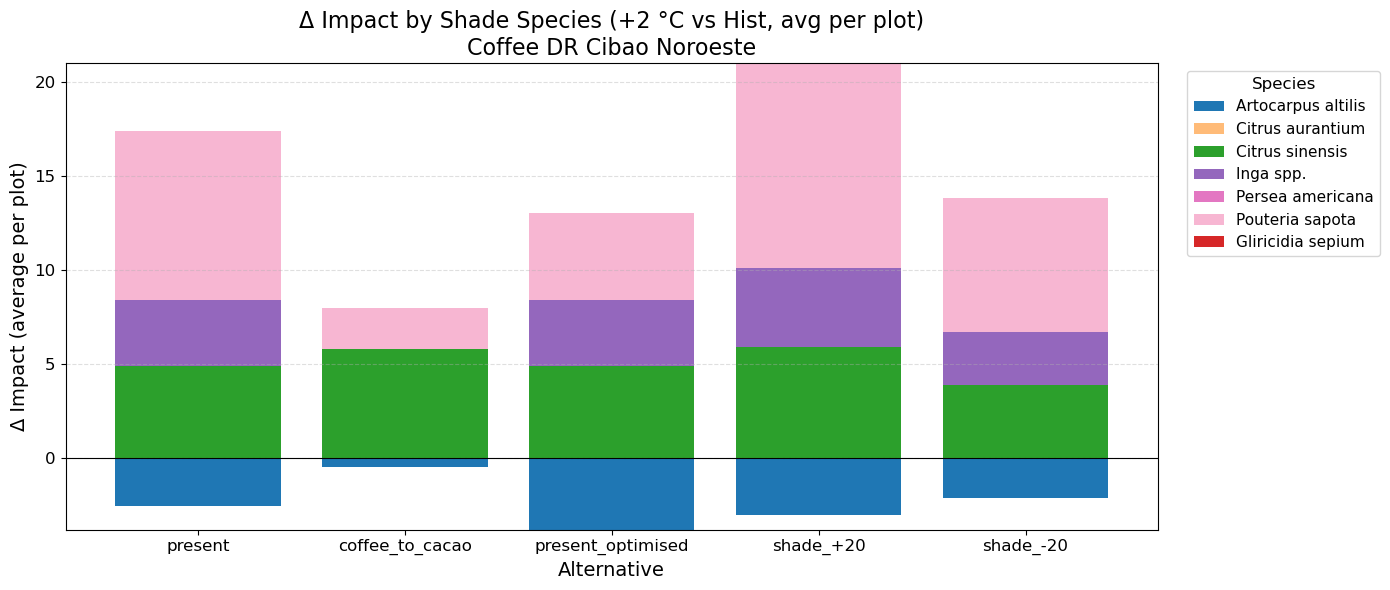

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots_change/Coffee__DR_Cibao_Noroeste_suitability_impact_change_4c.png


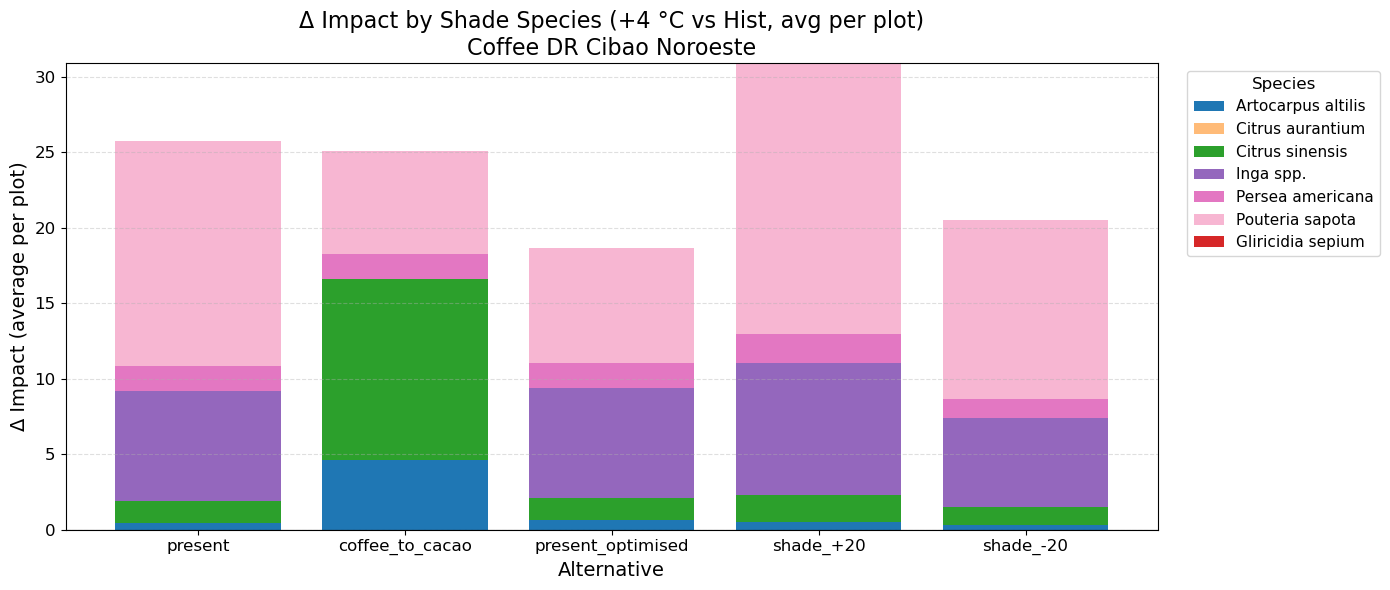

📊 Plotting Δ impacts for Coffee__Veracruz
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots_change/Coffee__Veracruz_suitability_impact_change_2c.png


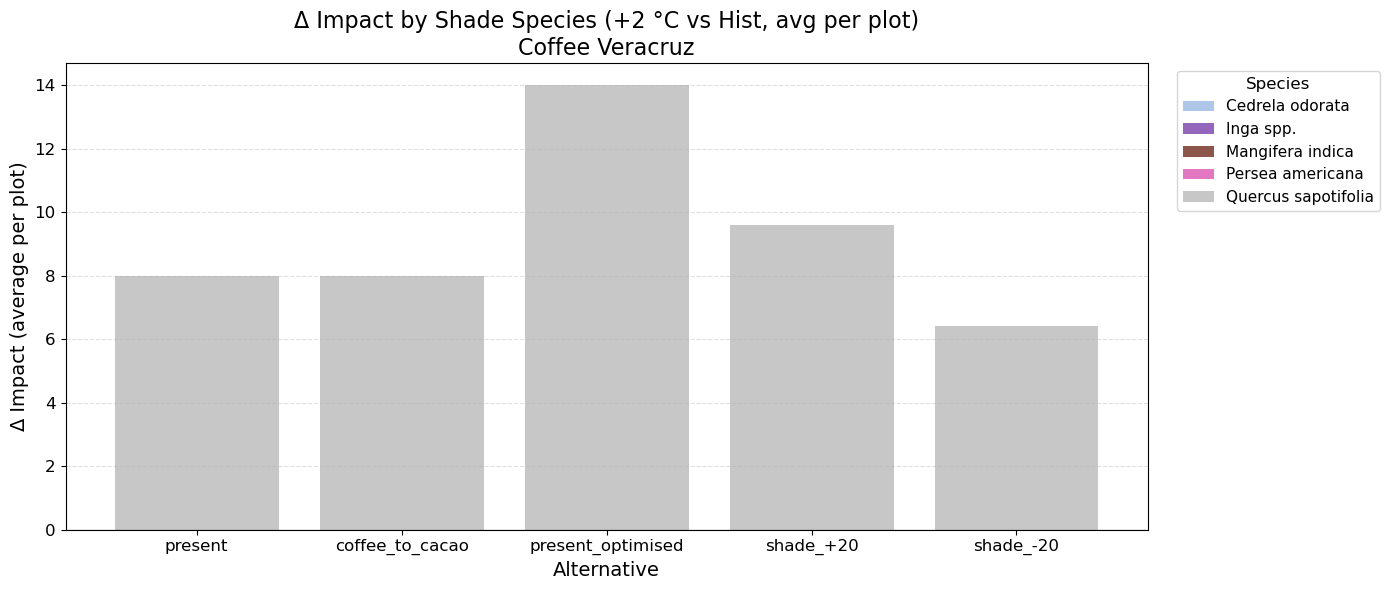

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots_change/Coffee__Veracruz_suitability_impact_change_4c.png


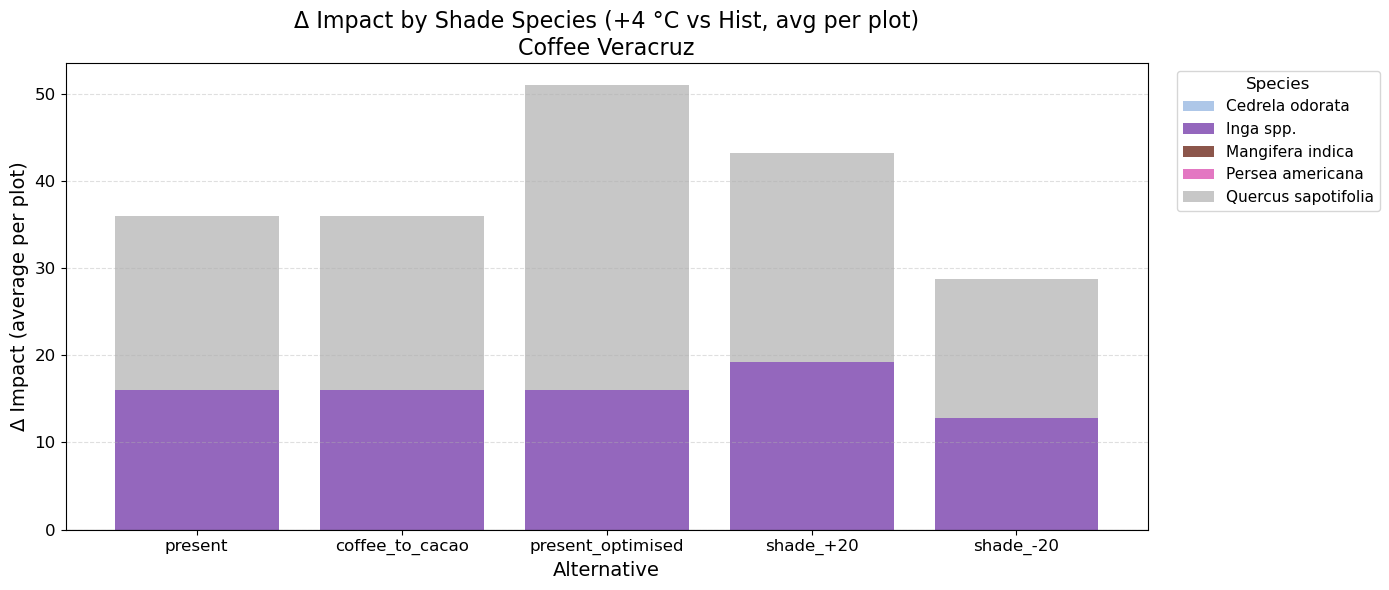

📊 Plotting Δ impacts for Coffee__WesternHighlands
💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots_change/Coffee__WesternHighlands_suitability_impact_change_2c.png


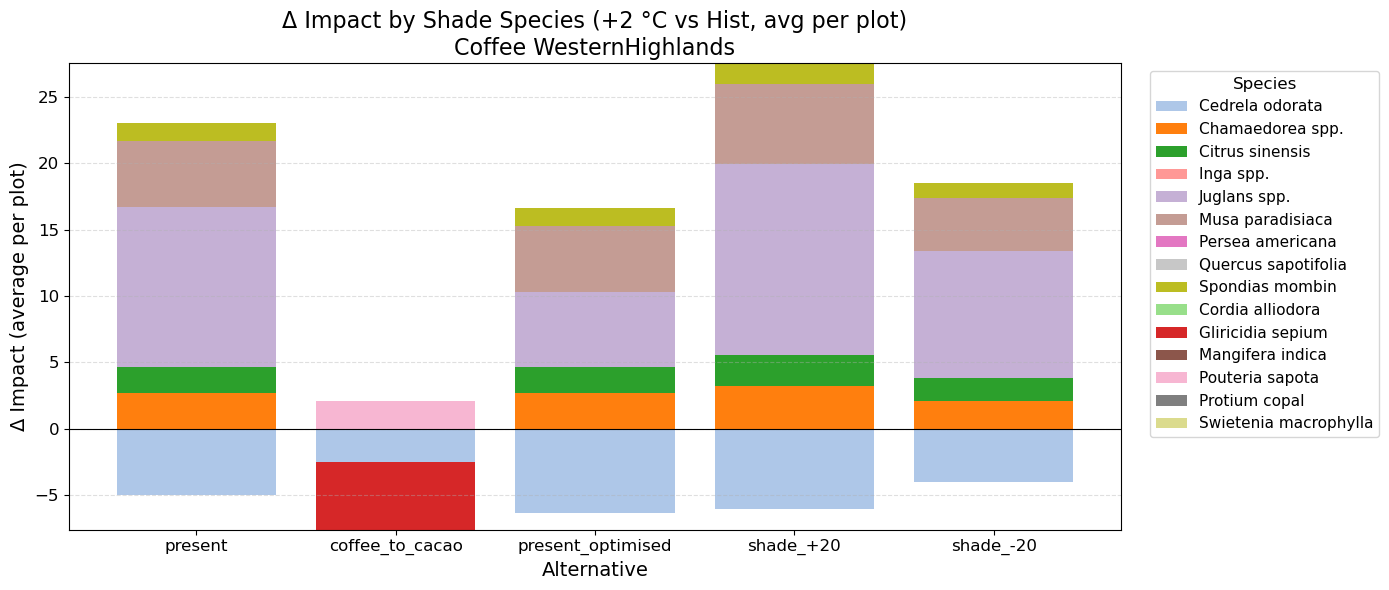

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_stacked_barplots_change/Coffee__WesternHighlands_suitability_impact_change_4c.png


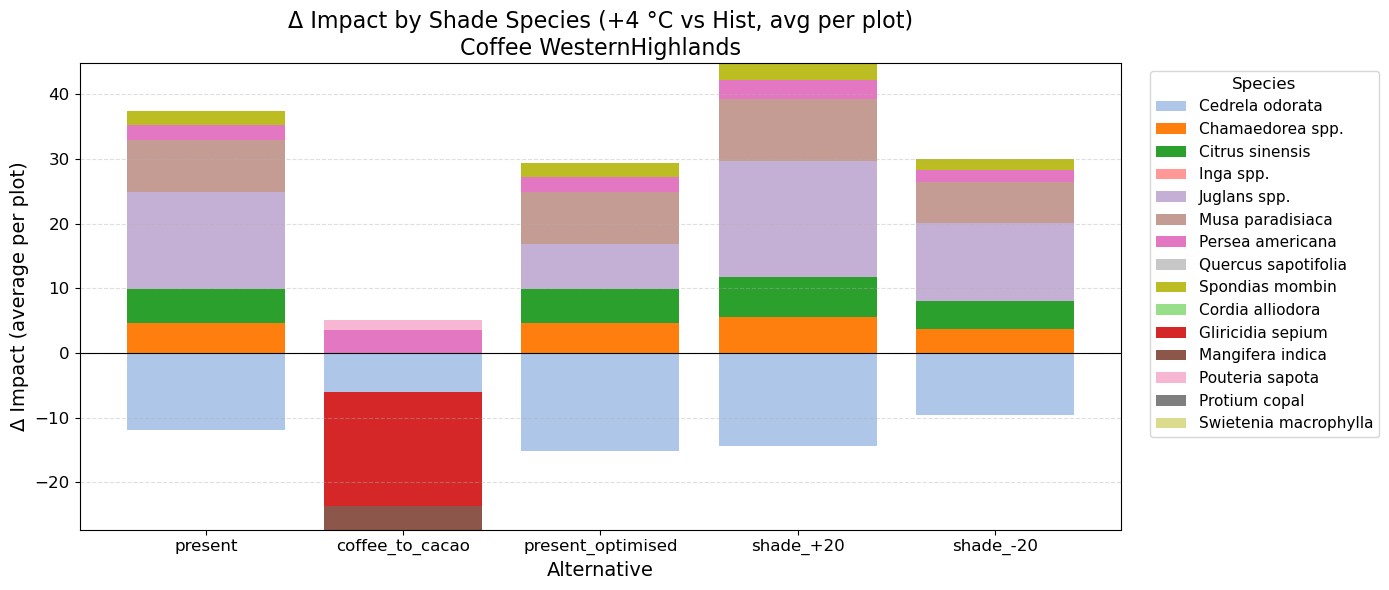

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "legend.title_fontsize": 12,
})

# Define main crops to exclude
MAIN_CROPS = {"Coffea arabica", "Theobroma cacao"}

subfolder = os.path.join(FIGURES_DIR, "suitability_stacked_barplots_change")
os.makedirs(subfolder, exist_ok=True)

# --- Build a global species color map ---
all_species = set()
for alternatives in system_results.values():
    for df in alternatives.values():
        all_species.update(df["species_clean"].unique())

# Exclude main crops
all_species = sorted([sp for sp in all_species if sp not in MAIN_CROPS])

palette = plt.cm.tab20.colors
species_colors = {sp: palette[i % len(palette)] for i, sp in enumerate(all_species)}

# Legend display mapping
species_display_map = {
    "Inga vera": "Inga spp.",
    "Inga sapindoides": "Inga spp."
}

# =========================
# LOOP OVER SYSTEMS
# =========================
for system_name, alternatives in system_results.items():
    print(f"📊 Plotting Δ impacts for {system_name}")

    # ---- Species-level summary of impacts ----
    impacts_summary = []
    for alt_name, gdf in alternatives.items():
        n_plots = gdf["geometry"].nunique()
        tmp = (
            gdf.groupby("species_clean")[["impact_now", "impact_2c", "impact_4c"]]
            .sum()
            .div(n_plots)
            .reset_index()
            .assign(alternative=alt_name)
        )
        impacts_summary.append(tmp)

    impacts_summary = pd.concat(impacts_summary, ignore_index=True)

    # ❌ remove main crops
    impacts_summary = impacts_summary[~impacts_summary["species_clean"].isin(MAIN_CROPS)]

    # Ensure alternatives are ordered
    alternatives_list = sorted(
        impacts_summary["alternative"].unique(),
        key=lambda x: (x != "present", x)
    )

    species = impacts_summary["species_clean"].unique()

    # -------- Helper function to plot deltas --------
    def plot_delta(ax, colname, label):
        bottom_pos = np.zeros(len(alternatives_list))
        bottom_neg = np.zeros(len(alternatives_list))

        for sp in species:
            subset = impacts_summary[impacts_summary["species_clean"] == sp].set_index("alternative")
            hist_vals = subset["impact_now"].reindex(alternatives_list)
            future_vals = subset[colname].reindex(alternatives_list)
            diff_vals = (future_vals - hist_vals).fillna(0)

            pos_vals = diff_vals.clip(lower=0)
            neg_vals = diff_vals.clip(upper=0)

            ax.bar(alternatives_list, pos_vals, bottom=bottom_pos,
                   color=species_colors[sp], label=sp)
            ax.bar(alternatives_list, neg_vals, bottom=bottom_neg,
                   color=species_colors[sp], label=sp)

            bottom_pos += pos_vals.values
            bottom_neg += neg_vals.values

        title_name = system_name.replace("__", " ").replace("_", " ")
        ax.set_title(f"Δ Impact by Shade Species ({label} vs Hist, avg per plot)\n{title_name}")
        ax.set_ylabel("Δ Impact (average per plot)")
        ax.set_xlabel("Alternative")
        ax.axhline(0, color="black", linewidth=0.8)
        ax.grid(axis="y", linestyle="--", alpha=0.4)

        # --- Deduplicate legend ---
        handles, labels = ax.get_legend_handles_labels()
        labels = [species_display_map.get(lbl, lbl) for lbl in labels]
        uniq = dict(zip(labels, handles))  # overwrite duplicates
        ax.legend(uniq.values(), uniq.keys(),
                  title="Species", bbox_to_anchor=(1.02, 1), loc="upper left")

    # -------- Δ Plot: +2 °C --------
    fig, ax = plt.subplots(figsize=(14, 6))
    plot_delta(ax, "impact_2c", "+2 °C")
    plt.tight_layout()
    fname = f"{system_name}_suitability_impact_change_2c.png".replace(" ", "_")
    outpath = os.path.join(subfolder, fname)
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"💾 Saved: {outpath}")
    plt.show()

    # -------- Δ Plot: +4 °C --------
    fig, ax = plt.subplots(figsize=(14, 6))
    plot_delta(ax, "impact_4c", "+4 °C")
    plt.tight_layout()
    fname = f"{system_name}_suitability_impact_change_4c.png".replace(" ", "_")
    outpath = os.path.join(subfolder, fname)
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"💾 Saved: {outpath}")
    plt.show()


## Suitability area comparison (shade vs main crops)

This script compares how climate change affects **shade species** and **main crops** across systems:

1. For each system (using the `"present"` alternative), compute the **average per-plot impact** (% of trees affected) for shade trees and main crops separately.  
2. Express future impacts (`impact_2c`, `impact_4c`) relative to present (`impact_now`), in **percentage point change**.  
3. Plot two panels:  
   - **Shade trees**: Δ impacts at +2 °C and +4 °C.  
   - **Main crops**: Δ impacts at +2 °C and +4 °C.  
4. Save figure to `FIGURES_DIR/suitability_area_comparison/suitability_area_difference_pct.png`.

📌 Notes:  
- Impacts are normalised by the average number of trees per plot (shade and main crops separately).  
- X-axis labels are system names, cleaned for readability.  
- Positive bars = more impact (higher losses) compared to present; negative bars = reduced impact.  


💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_area_comparison/suitability_area_difference_pct.png


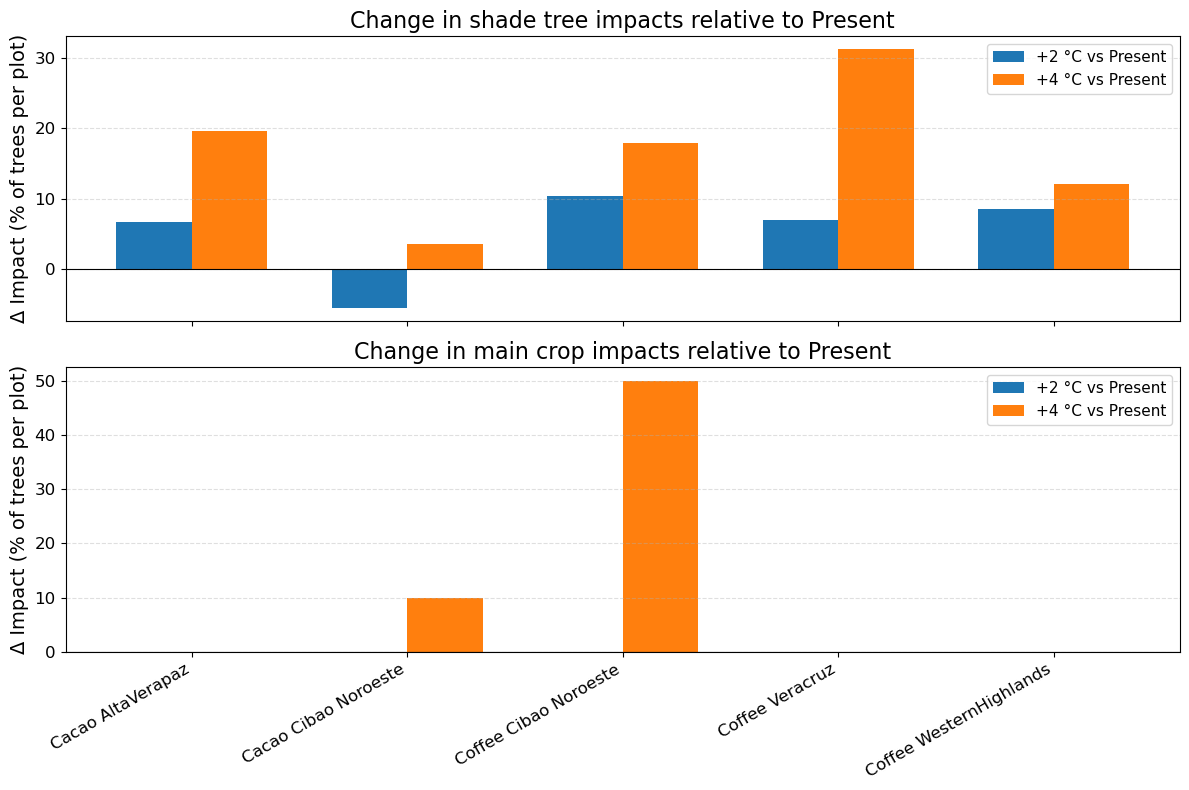

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "legend.title_fontsize": 12,
})

MAIN_CROPS = {"Coffea arabica", "Theobroma cacao"}

subfolder = os.path.join(FIGURES_DIR, "suitability_area_comparison")
os.makedirs(subfolder, exist_ok=True)

records_shade = []
records_main = []

# =========================
# COLLECT ACROSS SYSTEMS
# =========================
for system_name, alternatives in system_results.items():
    if "present" not in alternatives:
        continue

    gdf = alternatives["present"]
    n_plots = gdf["geometry"].nunique()

    # Total trees per plot (all species, normalised)
    total_trees = gdf[
    ~gdf['Scientific name'].isin(["Coffea arabica", "Theobroma cacao"])
]["Plants/ha"].sum() / n_plots
    total_trees_main = gdf[
    gdf['Scientific name'].isin(["Coffea arabica", "Theobroma cacao"])
]["Plants/ha"].sum() / n_plots

    # Shade species
    df_shade = gdf[~gdf["species_clean"].isin(MAIN_CROPS)]
    if not df_shade.empty:
        rec = {
            "system": system_name,
            "impact_now": (df_shade["impact_now"].sum() / n_plots) / total_trees * 100,
            "impact_2c": (df_shade["impact_2c"].sum() / n_plots) / total_trees * 100,
            "impact_4c": (df_shade["impact_4c"].sum() / n_plots) / total_trees * 100,
        }
        records_shade.append(rec)

    # Main crops
    df_main = gdf[gdf["species_clean"].isin(MAIN_CROPS)]
    if not df_main.empty:
        rec = {
            "system": system_name,
            "impact_now": (df_main["impact_now"].sum() / n_plots) / total_trees_main * 100,
            "impact_2c": (df_main["impact_2c"].sum() / n_plots) / total_trees_main * 100,
            "impact_4c": (df_main["impact_4c"].sum() / n_plots) / total_trees_main * 100,
        }
        records_main.append(rec)

impacts_shade = pd.DataFrame(records_shade)
impacts_main = pd.DataFrame(records_main)

# --- Compute differences (percentage points) ---
for df in [impacts_shade, impacts_main]:
    df["diff_2c"] = df["impact_2c"] - df["impact_now"]
    df["diff_4c"] = df["impact_4c"] - df["impact_now"]

# =========================
# PLOT REGIONAL COMPARISON
# =========================
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
width = 0.35

# Panel 1: Shade trees
x = np.arange(len(impacts_shade))
axes[0].bar(x - width/2, impacts_shade["diff_2c"], width, label="+2 °C vs Present")
axes[0].bar(x + width/2, impacts_shade["diff_4c"], width, label="+4 °C vs Present")
axes[0].set_ylabel("Δ Impact (% of trees per plot)")
axes[0].set_title("Change in shade tree impacts relative to Present")
axes[0].legend()
axes[0].axhline(0, color="black", linewidth=0.8)
axes[0].grid(axis="y", linestyle="--", alpha=0.4)

# Panel 2: Main crops
x2 = np.arange(len(impacts_main))
axes[1].bar(x2 - width/2, impacts_main["diff_2c"], width, label="+2 °C vs Present")
axes[1].bar(x2 + width/2, impacts_main["diff_4c"], width, label="+4 °C vs Present")
axes[1].set_xticks(x2)
axes[1].set_xticklabels(
    [name.replace("__", " ").replace("_", " ").replace("DR ", "") for name in impacts_main["system"]],
    rotation=30, ha="right"
)
axes[1].set_ylabel("Δ Impact (% of trees per plot)")
axes[1].set_title("Change in main crop impacts relative to Present")
axes[1].legend()
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()

# --- Save figure ---
outpath = os.path.join(subfolder, "suitability_area_difference_pct.png")
plt.savefig(outpath, dpi=300, bbox_inches="tight")
print(f"💾 Saved: {outpath}")
plt.show()


In [16]:
gdf[gdf['Scientific name']!="Coffea arabica"]["Plants/ha"].sum() / n_plots

210.0

# Let's now also model risks from extreme events

### for now we look just at drought, high temperature and tropical cyclones, but you could also model other hazards in a similar fashion

### we are only interested in drought for now. let's just assume a standard vulnerability, all species or similarly vulnerable

## Hazard generation from TerraClimate

This workflow builds **synthetic hazard fields** (temperature, drought) from TerraClimate data and saves them as CLIMADA `Hazard` objects.

### Steps
1. **Load climate inputs**  
   - For each scenario (`historical`, `plus2C`, `plus4C`), aggregate monthly temperature, precipitation, and PET.  

2. **Compute drought index**  
   - Calculate **SPEI-3** from monthly precipitation and PET.  
   - Collapse to yearly minimum values.  

3. **Sample extremes**  
   - Use a GEV-based sampling method to generate **100 synthetic years** of extreme fields:  
     - `TM` = annual maximum temperature.  
     - `SPEI` = annual minimum SPEI (driest years).  
     - (Precipitation sampling prepared but commented out.)  

4. **Create CLIMADA Hazard objects**  
   - Wrap synthetic fields into hazards (`TM`, `SPEI`).  
   - Store as `.hdf5` files in `DATA_DIR/hazards/`.  

5. **Load or save**  
   - If hazard files already exist, they are loaded directly.  
   - Otherwise, they are computed and saved.  

### Outputs
- `write_hazard_<scenario>_TM.hdf5`  
- `write_hazard_<scenario>_SPEI.hdf5`  
(saved to `DATA_DIR/hazards/`)  

### Notes
- `hazard_dict` stores the final hazard objects by scenario.  
- `ppt`/precipitation hazard is currently disabled.  
- Synthetic years allow risk models to sample beyond the short observational record.  


In [6]:
import os
import numpy as np
from config import bbox
from climada.hazard.base import Hazard
from config import DATA_DIR, TERRACLIMATE_PATHS
from utils_hazards import (
    get_aggregates,
    generate_gev_sample_field,
    create_hazard_from_array
)

# === Settings ===
LON_BOUNDS_DR = (bbox[0], bbox[2])        # (west, east)
LAT_BOUNDS_DR = (bbox[3], bbox[1])        # (north, south)
TERRACLIMATE_PATHS = {
    "plus2C": DATA_DIR / "terra_climate_scenarios_ncss/plus2C",
    "plus4C": DATA_DIR / "terra_climate_scenarios_ncss/plus4C",
    "historical": DATA_DIR / "terra_climate"
}

haz_types = ["TM"]   # ✅ only temperature mean
output_dir = os.path.join(DATA_DIR, "hazards")
os.makedirs(output_dir, exist_ok=True)

def get_hazard_path(scenario, haz_type):
    return os.path.join(output_dir, f"write_hazard_{scenario}_{haz_type}.hdf5")

def load_hazard_from_file(scenario, haz_type):
    path = get_hazard_path(scenario, haz_type)
    haz = Hazard.from_hdf5(path)
    print(f"📂 Loaded: {path}")
    return haz

def save_hazard_to_file(hazard, scenario, haz_type):
    path = get_hazard_path(scenario, haz_type)
    hazard.write_hdf5(path)
    print(f"💾 Saved: {path}")

# === Main loop ===
hazard_dict = {}

for scenario, path in TERRACLIMATE_PATHS.items():
    print(f"\n🚀 Processing scenario: {scenario}")
    all_exist = all(os.path.exists(get_hazard_path(scenario, haz_type)) for haz_type in haz_types)

    if all_exist:
        print("✅ All hazard files found — skipping computation.")
        hazard_dict[scenario] = {
            haz_type: load_hazard_from_file(scenario, haz_type)
            for haz_type in haz_types
        }
        continue

    print("🧮 Computing hazards...")
    agg = get_aggregates(path, variables=("tmean",))
    tmean = agg["tmean"]

    print("🎲 Sampling synthetic HOT years (GEV)...")
    tmean_100yrs = generate_gev_sample_field(tmean, n_years=100)

    print("🌍 Creating CLIMADA Hazard object...")
    haz_tmean = create_hazard_from_array(tmean_100yrs, haz_type="TM", units="degC")

    # Save to disk
    save_hazard_to_file(haz_tmean, scenario, "TM")

    hazard_dict[scenario] = {
        "TM": haz_tmean
    }



🚀 Processing scenario: plus2C
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_plus2C_TM.hdf5

🚀 Processing scenario: plus4C
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_plus4C_TM.hdf5

🚀 Processing scenario: historical
✅ All hazard files found — skipping computation.
📂 Loaded: /Users/szelie/data/biofincas/hazards/write_hazard_historical_TM.hdf5


## Return period curves for hazards

This script plots **return period (extreme value) curves** for a chosen hazard at a specific coordinate.

### Steps
1. **Select location**  
   - Example: Cibao Noroeste (`lon=-70, lat=19.5`).  
   - Find nearest grid cell in the hazard centroids.  

2. **Extract intensities**  
   - Take hazard values at that location for all synthetic years.  
   - Remove NaNs, sort descending.  

3. **Compute return periods**  
   - Use rank-based formula: `(N+1)/rank`.  
   - Gives recurrence interval for each intensity.  

4. **Plot**  
   - Return period curves for each scenario (`historical`, `plus2C`, `plus4C`).  
   - Log-scale x-axis (return period in years).  

### Notes
- `haz_type` can be `"TM"` (temperature extremes) or `"SPEI"` (drought).  
- Curves allow comparison of how extremes shift under climate scenarios.  
- Colours: blue (historical), orange (+2 °C), red (+4 °C).  


## Return period curves for hazards

This script plots **return period (extreme value) curves** for a chosen hazard at a specific coordinate.

### Steps
1. **Select location**  
   - Example: Cibao Noroeste (`lon=-70, lat=19.5`).  
   - Find nearest grid cell in the hazard centroids.  

2. **Extract intensities**  
   - Take hazard values at that location for all synthetic years.  
   - Remove NaNs, sort descending.  

3. **Compute return periods**  
   - Use rank-based formula: `(N+1)/rank`.  
   - Gives recurrence interval for each intensity.  

4. **Plot**  
   - Return period curves for each scenario (`historical`, `plus2C`, `plus4C`).  
   - Log-scale x-axis (return period in years).  

### Notes
- `haz_type` can be `"TM"` (temperature extremes) or `"SPEI"` (drought).  
- Curves allow comparison of how extremes shift under climate scenarios.  
- Colours: blue (historical), orange (+2 °C), red (+4 °C).  


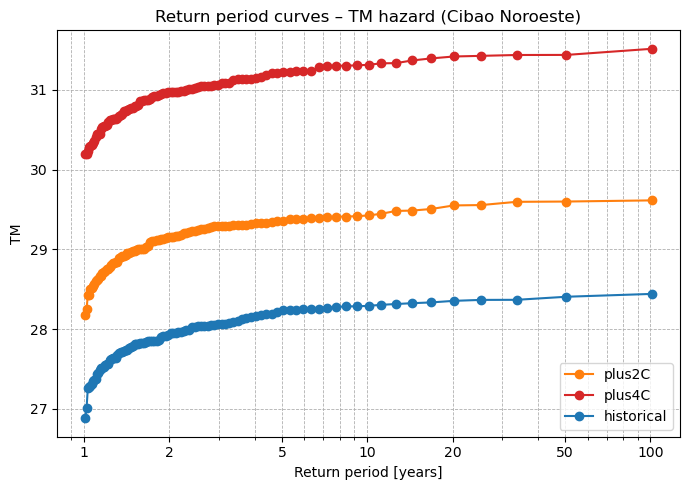

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Example: pick nearest coord to Cibao
def get_coord_index(haz, lon, lat):
    dist2 = (haz.centroids.lat - lat)**2 + (haz.centroids.lon - lon)**2
    return dist2.argmin()

# --- Settings ---
haz_type = "TM"   # or "TM"
lon, lat = -70, 19.5
colors = {"historical": "tab:blue", "plus2C": "tab:orange", "plus4C": "tab:red"}

plt.figure(figsize=(7,5))

for scenario, hazards in hazard_dict.items():
    if haz_type not in hazards:
        continue

    haz = hazards[haz_type]
    coord_idx = get_coord_index(haz, lon, lat)

    # Extract intensities for this coordinate
    values = haz.intensity[:, coord_idx].toarray().ravel()
    values = values[~np.isnan(values)]

    # Sort & return periods
    sorted_vals = np.sort(values)[::-1]
    N = len(sorted_vals)
    ranks = np.arange(1, N+1)
    return_periods = (N+1) / ranks

    # Plot
    plt.plot(return_periods, sorted_vals, marker="o", lw=1.5,
             color=colors.get(scenario, "gray"), label=scenario)

plt.xscale("log")
plt.xlabel("Return period [years]")
plt.ylabel("TM")
plt.title(f"Return period curves – {haz_type} hazard (Cibao Noroeste)")
plt.grid(True, which="both", ls="--", lw=0.6)
plt.xticks([1, 2, 5, 10, 20, 50, 100], labels=["1","2","5","10","20","50","100"])
plt.legend()
plt.tight_layout()
plt.show()


### let's also load tropical cyclone for the north atlantic and west pacific basins

In [8]:
from climada.util.api_client import Client
from climada.hazard import Hazard

client = Client()

# --- HISTORICAL ---
tc_hist_na = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "NA", "event_type": "synthetic", "climate_scenario": "None"}
)
tc_hist_ep = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "EP", "event_type": "synthetic", "climate_scenario": "None"}
)

tc_hist_all = Hazard.concat([tc_hist_na, tc_hist_ep])

# --- FUTURE (2°C / RCP4.5 around 2060) ---
tc_future_na = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "NA", "event_type": "synthetic", "climate_scenario": "rcp45", "ref_year": "2060"}
)
tc_future_ep = client.get_hazard(
    'tropical_cyclone',
    properties={"genesis_basin": "EP", "event_type": "synthetic", "climate_scenario": "rcp45", "ref_year": "2060"}
)

tc_future_all = Hazard.concat([tc_future_na, tc_future_ep])




In [9]:
# --- Add to your hazard dictionary ---
hazard_dict['historical']["TC"] = tc_hist_all
hazard_dict["plus2C"]["TC"] = tc_future_all

### Impact function definitions

The cells below define **impact functions (IMPFs)** for different hazards affecting perennial crops (coffee, cacao):

- **Temperature & Precipitation**  
  Species-specific trapezoidal functions based on optimal and tolerance ranges.  
  If thresholds are missing, fallback curves are derived from the local mean climate.

- **Tropical Cyclones (TC)**  
  Wind–damage curves for high, medium, and low canopy vulnerability classes, plus a default no-impact case.

- **Drought (DR)**  
  Impact functions based on species’ tolerance ranges in SPEI. Includes a generic fallback drought curve.

Finally, a helper links each crop species in the exposure dataframe to the appropriate impact function IDs (TM, PR, DR, TC).


In [10]:
hazard_dict

{'plus2C': {'TM': <climada.hazard.base.Hazard at 0x385e14610>,
  'TC': <climada.hazard.base.Hazard at 0x426188950>},
 'plus4C': {'TM': <climada.hazard.base.Hazard at 0x317719b90>},
 'historical': {'TM': <climada.hazard.base.Hazard at 0x426293dd0>,
  'TC': <climada.hazard.base.Hazard at 0x4262016d0>}}

## Impact function definitions

This script defines **impact functions** for different hazards (tropical cyclones, drought, and heat) to use in CLIMADA.  
Impact functions describe how hazard intensity translates into expected damage for crops/trees.

### Hazards & vulnerability classes
1. **Tropical cyclones (`TC`)**  
   - Intensity: wind speed (0–70 m/s).  
   - Curves:  
     - High vulnerability → fragile/tall shade species (damage starts ~35 m/s).  
     - Medium vulnerability → crops like coffee, cacao, fruit (~40 m/s).  
     - Low vulnerability → tolerant hardwoods/palms (~48 m/s).  
   - Cap = maximum mean damage degree (MDD).  

2. **Drought (`DR`, SPEI)**  
   - Intensity: Standardised Precipitation–Evapotranspiration Index (SPEI).  
   - Curves:  
     - High vulnerability → damage onset at SPEI ≈ 1.0.  
     - Medium vulnerability → onset ~1.5.  
     - Low vulnerability → onset ~2.0.  

3. **Heat (`TM`)**  
   - Intensity: mean annual temperature (20–35 °C).  
   - Curves:  
     - High vulnerability → coffee/cacao; onset ≈ 26 °C.  
     - Medium vulnerability → fruit trees; onset ≈ 28 °C.  
     - Low vulnerability → tolerant hardwoods/palms; onset ≈ 30 °C.  

### Implementation details
- Each hazard type has an `ImpactFuncSet` with several `ImpactFunc` objects.  
- Each curve uses a quadratic growth after onset until reaching a cap.  
- `paa` (probability of asset affected) is set to 1 for all exposed assets.  
- A **default function** (ID=0) represents “unknown” species (no damage).  

### Outputs
- `define_tc_impfs()`, `define_drought_impfs()`, and `define_heat_impfs()` each return an `ImpactFuncSet`.  
- These sets can be attached to exposures in CLIMADA to simulate impacts.  


In [11]:
import numpy as np
from climada.entity import ImpactFunc, ImpactFuncSet

# === Tropical cyclone impact functions (wind speed in m/s) ===
def define_tc_impfs():
    impf_set = ImpactFuncSet()
    intensity = np.linspace(0, 70, 15)  # 0–70 m/s

    def make_tc_curve(i, label, onset, cap, scale):
        curve = np.zeros_like(intensity, dtype=float)
        mask = intensity >= onset
        curve[mask] = cap * np.clip(((intensity[mask] - onset) / scale) ** 2, 0, 1)
        curve = np.minimum(curve, cap)
        return ImpactFunc(
            haz_type="TC",
            id=i,
            name=label,
            intensity=intensity,
            mdd=curve,
            paa=np.ones_like(curve),
        )

    # Reduced differences between classes
    impf_set.append(make_tc_curve(
        1, "High vulnerability (fragile/tall shade)", onset=35, cap=0.5, scale=30
    ))
    impf_set.append(make_tc_curve(
        2, "Medium vulnerability (coffee, cacao, fruit)", onset=40, cap=0.45, scale=32
    ))
    impf_set.append(make_tc_curve(
        3, "Low vulnerability (hardwoods/palms)", onset=48, cap=0.35, scale=35
    ))

    # Default: no damage
    impf_set.append(
        ImpactFunc(
            haz_type="TC",
            id=0,
            name="Unknown / default",
            intensity=intensity,
            mdd=np.zeros_like(intensity),
            paa=np.zeros_like(intensity),
        )
    )
    return impf_set


# === Drought (SPEI) impact functions ===
def define_drought_impfs():
    impf_set = ImpactFuncSet()
    intensity = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5])  # SPEI scale

    def make_drought_curve(i, label, onset, cap, scale):
        curve = np.zeros_like(intensity, dtype=float)
        mask = intensity >= onset
        curve[mask] = cap * np.clip(((intensity[mask] - onset) / scale) ** 2, 0, 1)
        curve = np.minimum(curve, cap)
        return ImpactFunc(
            haz_type="DR",
            id=i,
            name=label,
            intensity=intensity,
            mdd=curve,
            paa=np.ones_like(curve),
        )

    # High vulnerability: earlier onset, higher cap
    impf_set.append(make_drought_curve(
        1, "High vulnerability", onset=1.0, cap=1, scale=2.0
    ))

    # Medium vulnerability: later onset, medium cap
    impf_set.append(make_drought_curve(
        2, "Medium vulnerability", onset=1.5, cap=1, scale=2.5
    ))

    # Low vulnerability: much later onset, lower cap
    impf_set.append(make_drought_curve(
        3, "Low vulnerability", onset=2.0, cap=1, scale=3.0
    ))

    # Default: no damage
    impf_set.append(
        ImpactFunc(
            haz_type="DR",
            id=0,
            name="Unknown / default",
            intensity=intensity,
            mdd=np.zeros_like(intensity),
            paa=np.zeros_like(intensity),
        )
    )
    return impf_set
# === Heat (tmean) impact functions (degC) ===
def define_heat_impfs():
    impf_set = ImpactFuncSet()
    # Use a high range to only penalise extreme chronic heat
    intensity = np.linspace(20, 35, 16)  # mean annual temperature

    def make_heat_curve(i, label, onset, cap, scale):
        curve = np.zeros_like(intensity, dtype=float)
        mask = intensity >= onset
        curve[mask] = cap * np.clip(((intensity[mask] - onset) / scale) ** 2, 0, 1)
        curve = np.minimum(curve, cap)
        return ImpactFunc(
            haz_type="TM",
            id=i,
            name=label,
            intensity=intensity,
            mdd=curve,
            paa=np.ones_like(curve),
        )

    # High vulnerability: sensitive crops (coffee, cacao) → damage only from ~27°C
    impf_set.append(make_heat_curve(
        1, "High vulnerability (coffee, cacao)", onset=26, cap=1, scale=10
    ))

    # Medium vulnerability: fruit trees → threshold ~29°C
    impf_set.append(make_heat_curve(
        2, "Medium vulnerability (fruit trees)", onset=28, cap=1, scale=10
    ))

    # Low vulnerability: tolerant hardwoods → threshold ~31°C
    impf_set.append(make_heat_curve(
        3, "Low vulnerability (hardwoods/palms)", onset=30, cap=1, scale=10
    ))

    # Default: no damage
    impf_set.append(
        ImpactFunc(
            haz_type="TM",
            id=0,
            name="Unknown / default",
            intensity=intensity,
            mdd=np.zeros_like(intensity),
            paa=np.zeros_like(intensity),
        )
    )
    return impf_set






## Species–hazard vulnerability mapping

This section links each species to a **vulnerability class** (impact function ID) for:  
- Tropical cyclones (`impf_TC`)  
- Drought (`impf_DR`)  
- Heat (`impf_TM`)  

The function `assign_impact_function_ids` assigns the correct impact function ID to each species row, so exposures can be evaluated with the corresponding `ImpactFuncSet`.  


In [12]:
import numpy as np
import pandas as pd
from climada.entity import ImpactFunc, ImpactFuncSet

# === Species vulnerability mapping ===
species_tc_map = {
    "Coffea arabica": 2,
    "Theobroma cacao": 2,
    "Musa paradisiaca": 1,
    "Gliricidia sepium": 1,
    "Inga vera": 1,
    "Inga sapindoides": 1,
    "Mimosa scabrella": 1,
    "Enterolobium cyclocarpum": 1,
    "Swietenia macrophylla": 3,
    "Cedrela odorata": 3,
    "Quercus sapotifolia": 3,
    "Juglans spp.": 3,
    "Mangifera indica": 2,
    "Citrus aurantium": 2,
    "Citrus sinensis": 2,
    "Persea americana": 2,
    "Pouteria sapota": 2,
    "Artocarpus altilis": 2,
    "Spondias mombin": 2,
    "Protium copal": 2,
    "Chamaedorea spp.": 3,
}

species_dr_map = {
    "Coffea arabica": 1,
    "Theobroma cacao": 1,
    "Musa paradisiaca": 1,
    "Gliricidia sepium": 3,
    "Inga vera": 2,
    "Inga sapindoides": 2,
    "Mimosa scabrella": 3,
    "Enterolobium cyclocarpum": 3,
    "Swietenia macrophylla": 3,
    "Cedrela odorata": 3,
    "Quercus sapotifolia": 3,
    "Juglans spp.": 3,
    "Mangifera indica": 2,
    "Citrus aurantium": 2,
    "Citrus sinensis": 2,
    "Persea americana": 1,
    "Pouteria sapota": 2,
    "Artocarpus altilis": 1,
    "Spondias mombin": 2,
    "Protium copal": 2,
    "Chamaedorea spp.": 3,
}

species_tm_map = {
    "Coffea arabica": 1,     # high vulnerability to extreme heat
    "Theobroma cacao": 1,
    "Musa paradisiaca": 2,   # medium
    "Gliricidia sepium": 3,  # hardy shade tree
    "Inga vera": 3,
    "Inga sapindoides": 3,
    "Mimosa scabrella": 3,
    "Enterolobium cyclocarpum": 3,
    "Swietenia macrophylla": 3,  # low
    "Cedrela odorata": 3,
    "Quercus sapotifolia": 3,
    "Juglans spp.": 3,
    "Mangifera indica": 2,
    "Citrus aurantium": 2,
    "Citrus sinensis": 2,
    "Persea americana": 2,
    "Pouteria sapota": 2,
    "Artocarpus altilis": 2,
    "Spondias mombin": 2,
    "Protium copal": 2,
    "Chamaedorea spp.": 3,
}

# === Assign IMPF IDs (species-based) ===
def assign_impact_function_ids(df):
    df["impf_TC"] = df["species_clean"].map(species_tc_map).fillna(0).astype(int)
    df["impf_DR"] = df["species_clean"].map(species_dr_map).fillna(0).astype(int)
    df["impf_TM"] = df["species_clean"].map(species_tm_map).fillna(0).astype(int)
    return df

# === Build ImpactFuncSets ===
tc_impfs = define_tc_impfs()
dr_impfs = define_drought_impfs()
tm_impfs = define_heat_impfs()


2025-08-29 13:18:48,739 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2025-08-29 13:18:48,740 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2025-08-29 13:18:48,741 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


## Assigning impact functions to exposures

This step attaches the correct **impact function IDs (IMPFs)** to each exposure entry:

1. **Species-based mapping**  
   - Use `assign_impact_function_ids` to assign baseline vulnerability classes for drought, heat, and cyclones.

2. **Scenario-based adjustment**  
   - Alternatives with less shade (`-20`) → shift to more vulnerable classes.  
   - Alternatives with more shade (`+20`, `shadeplus`) → shift to less vulnerable classes.  
   - Otherwise leave unchanged.

3. **Final exposures**  
   - `value` is set to `Plants/ha`.  
   - Updated exposures are stored back into the `exposures` dictionary.  

📌 This allows each scenario (with different shade management) to be evaluated with hazard-specific vulnerability functions.


In [16]:
from climada.entity import Exposures
import pandas as pd

def adjust_with_scenario(row, alt_name):
    """Adjust IMPF classes based on scenario name (shade changes)."""
    dr_class, heat_class, tc_class = row["impf_DR"], row["impf_TM"], row["impf_TC"]

    if "-20" in alt_name:  # less shade
        heat_class = max(1, heat_class - 1)   # heat: more vulnerable
        dr_class   = max(1, heat_class - 1)    # drought: more vulnerable
        tc_class   = max(1, tc_class - 1)     # cyclones: more vulnerable

    elif "+20" in alt_name or "shadeplus" in alt_name:  # more shade
        heat_class = min(3, heat_class + 1)   # heat: less vulnerable
        dr_class   = min(3, tc_class + 1)     # drought: less vulnerable
        tc_class   = min(3, tc_class + 1)     # cyclones: less vulnerable

    # If no shade modifier in alt_name → leave unchanged
    return pd.Series([dr_class, heat_class, tc_class],
                     index=["impf_DR", "impf_TM", "impf_TC"])

# === Assign impact functions to *all* exposures ===
for system_name, alternatives in exposures.items():
    for alt_name, exp in alternatives.items():
        gdf = exposures[system_name][alt_name].gdf

        # --- Step 1: species-based mapping ---
        gdf = assign_impact_function_ids(gdf)

        # --- Step 2: adjust based on scenario name ---
        gdf[["impf_DR", "impf_TM", "impf_TC"]] = gdf.apply(
            lambda row: adjust_with_scenario(row, alt_name), axis=1
        )

        # Exposure value = number of plants
        gdf.value = gdf["Plants/ha"]

        # Replace back in dict
        exposures[system_name][alt_name] = Exposures(gdf)

        print(f"✅ Assigned IMPFs (species + shade adjustment from scenario) for {system_name} | {alt_name}")


✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__AltaVerapaz | present
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__AltaVerapaz | shade_-20
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__AltaVerapaz | shade_+20
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__AltaVerapaz | cacao_to_coffee
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__DR_Cibao_Noroeste | present
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__DR_Cibao_Noroeste | shade_-20
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__DR_Cibao_Noroeste | shade_+20
✅ Assigned IMPFs (species + shade adjustment from scenario) for Cacao__DR_Cibao_Noroeste | cacao_to_coffee
✅ Assigned IMPFs (species + shade adjustment from scenario) for Coffee__DR_Cibao_Noroeste | present
✅ Assigned IMPFs (species + shade adjustment from scenario) for Coffee__DR_Cibao_Noroeste | shade_-20
✅ Assi

#let's just make the SPEI positive, will be easier, caregul not to run this cell twice...

In [18]:
# for scenario in hazard_dict:
#     hazard_dict[scenario]['SPEI'].intensity = -hazard_dict[scenario]['SPEI'].intensity #climada struggles with negative hazard values
#     for haz in hazard_dict[scenario]:
#         hazard_dict[scenario][haz].event_id = np.array(hazard_dict[scenario][haz].event_id)

# impact calculation:

In [20]:
import copy
from climada.engine import ImpactCalc
from climada.entity import ImpactFuncSet

# === Helper: merge multiple ImpactFuncSets into one ===
def merge_impf_sets(*sets):
    merged = ImpactFuncSet()
    for s in sets:
        for haz_type, funcs in s.get_func().items():
            for _, func in funcs.items():
                merged.append(func)
    return merged

# === Merge your TC + DR impact functions ===
impf_set = merge_impf_sets(tc_impfs, dr_impfs, tm_impfs)

# === Loop through systems and compute impacts ===
impact_results = {}
for system_name, alternatives in exposures.items():

    print(system_name)

    impact_results[system_name] = {}
    print(system_name)
    for alt_name, exp in alternatives.items():
        print(f"📂 {system_name} - {alt_name}")
        impact_results[system_name][alt_name] = {}

        for scenario in hazard_dict:
            impact_results[system_name][alt_name][scenario] = {}

            for haz_type in hazard_dict[scenario]:
                print(haz_type)
                # ✅ Normalise hazard type (copy so we don’t mutate hazard_dict)
                haz_type_norm = "DR" if haz_type == "SPEI" else haz_type
                
                hazard_dict[scenario][haz_type].haz_type = haz_type_norm
                # ✅ Use merged impact function set
                impact = ImpactCalc(exp, impf_set, hazard_dict[scenario][haz_type]).impact(save_mat=True)
                impact_results[system_name][alt_name][scenario][haz_type_norm] = impact

print(f"✅ Finished impacts for {len(impact_results)} systems")


2025-08-29 13:27:22,313 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2025-08-29 13:27:22,314 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2025-08-29 13:27:22,315 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
Cacao__AltaVerapaz
Cacao__AltaVerapaz
📂 Cacao__AltaVerapaz - present
TM
TC
TM
TM
TC
📂 Cacao__AltaVerapaz - shade_-20
TM
TC
TM
TM
TC
📂 Cacao__AltaVerapaz - shade_+20
TM
TC
TM
TM
TC
📂 Cacao__AltaVerapaz - cacao_to_coffee
TM
TC
TM
TM
TC
Cacao__DR_Cibao_Noroeste
Cacao__DR_Cibao_Noroeste
📂 Cacao__DR_Cibao_Noroeste - present
TM
TC
TM
TM
TC
📂 Cacao__DR_Cibao_Noroeste - shade_-20
TM
TC
TM
TM
TC
📂 Cacao__DR_Cibao_Noroeste - shade_+20
TM
TC
TM
TM
TC
📂 Cacao__DR_Cibao_Noroeste - cacao_to_coffee
TM
TC
TM
TM
TC
Coffee__DR_Cibao_Noroeste
Coffee__DR_Cibao_Noroeste
📂 Coffee__DR_Cibao_Noroeste - present
TM
TC
TM
TM
TC
📂 Coffee__DR_Cibao_Noroeste - shade_-20
TM
TC
TM
TM


## Frequency curves for Cibao systems

This script plots **frequency curves** of climate impacts (trees lost as % of exposure) for Cibao systems:

1. Loop over hazards (`DR`, `TM`, `TC`) and alternatives.  
2. Compute frequency curves (`impact.calc_freq_curve()`) under the +2 °C scenario.  
3. Normalise by total trees per system/alternative.  
4. Plot % trees lost vs. return period (log-scale).  
5. Save figures to `FIGURES_DIR/freq_curves/`.

📌 Focused only on systems with `"Cibao"` in their name.  


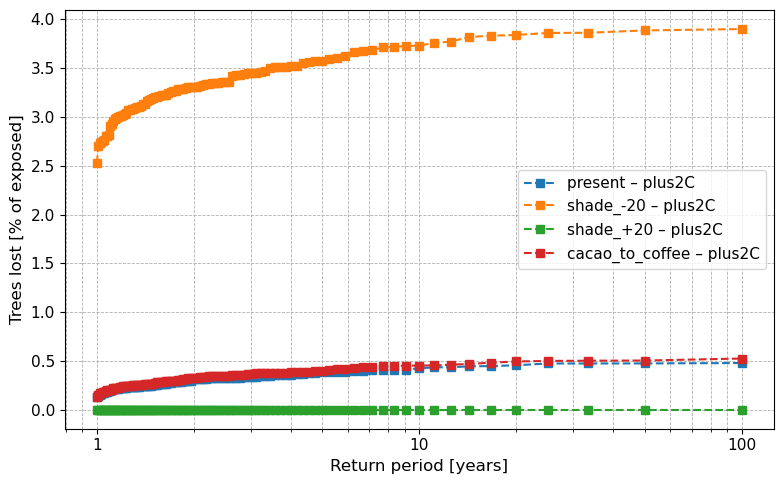

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Cacao__DR_Cibao_Noroeste_TM.png


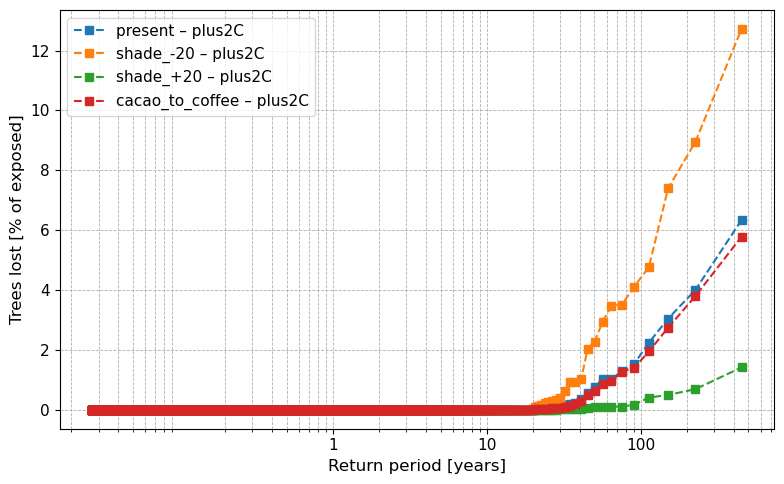

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Cacao__DR_Cibao_Noroeste_TC.png


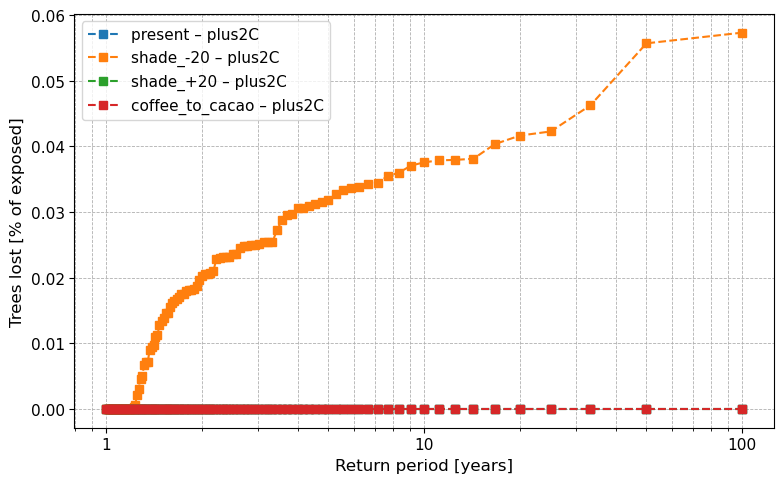

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__DR_Cibao_Noroeste_TM.png


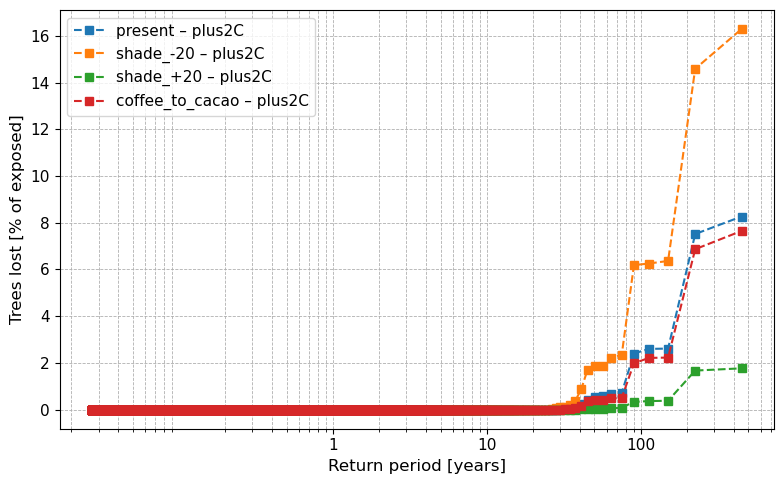

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/freq_curves/Coffee__DR_Cibao_Noroeste_TC.png


In [24]:
import os
import matplotlib.pyplot as plt
from config import FIGURES_DIR

# === Matplotlib style ===
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

hazards_to_plot = {
    "TM": "Heat",
    "TC":"Tropical Cyclone"
}

# Create subdirectory inside FIGURES_DIR
out_dir = os.path.join(FIGURES_DIR, "freq_curves")
os.makedirs(out_dir, exist_ok=True)

# === Loop through systems and hazards (Cibao only) ===
for system_name, alternatives in impact_results.items():
    if "Cibao" not in system_name:   # 🔑 filter to Cibao
        continue

    for haz_code, haz_label in hazards_to_plot.items():
        plt.figure(figsize=(8, 5))

        for alt_name, haz_dict in alternatives.items():
            for scenario, style in [("plus2C", "--")]:
                impact = haz_dict[scenario][haz_code]
                freq_curve = impact.calc_freq_curve()

                # Normalise by total trees
                total_trees = exposures[system_name][alt_name].gdf.value.sum()
                perc_loss = (freq_curve.impact / total_trees) * 100

                plt.plot(
                    freq_curve.return_per,
                    perc_loss,
                    label=f"{alt_name} – {scenario}",
                    linestyle=style,
                    marker="s",
                )

        plt.xlabel("Return period [years]")
        plt.ylabel("Trees lost [% of exposed]")
        #plt.title(f"{system_name}\n{haz_label} – Risk shade trees (+2 °C Scenario)")
        plt.legend()
        plt.grid(True, which="both", linestyle="--", linewidth=0.6)
        plt.xscale("log")
        plt.xticks([1, 10, 100], labels=["1", "10", "100"])
        plt.tight_layout()

        # Save to file (system + hazard code)
        fname = f"{system_name}_{haz_code}.png"
        fpath = os.path.join(out_dir, fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight")
        plt.show()

        print(f"💾 Saved: {fpath}")


## Barplots of expected annual loss

This script summarises **expected annual impact (EAI)** as % of trees lost for each system, hazard, and alternative.

### Steps
1. For each system × alternative × hazard:  
   - Compute `aai_agg` (expected annual impact).  
   - Normalise by total trees → % loss.  
   - Store results in a summary dataframe.  

2. Plot barplots:  
   - X-axis = alternatives,  
   - Y-axis = % trees lost,  
   - Hue = scenario (`historical` vs `plus2C`).  

3. Save figures per system–hazard to `FIGURES_DIR/barplots/`.

📌 Skips the +4 °C scenario (only historical and +2 °C shown).  


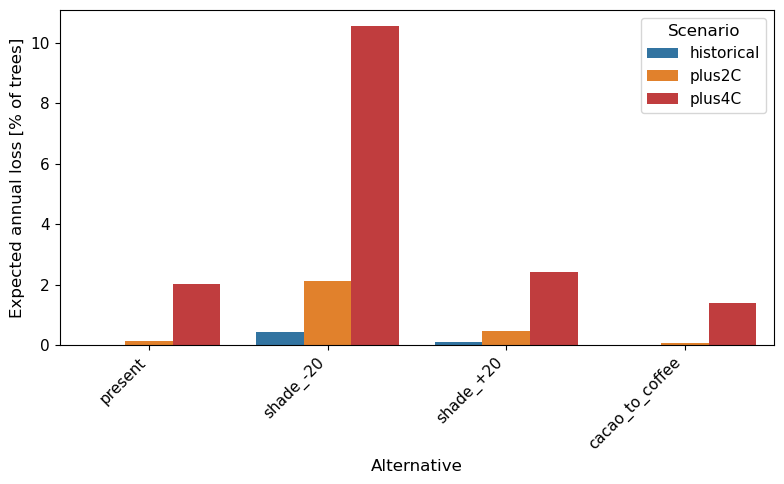

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Cacao__AltaVerapaz_TM_barplot.png


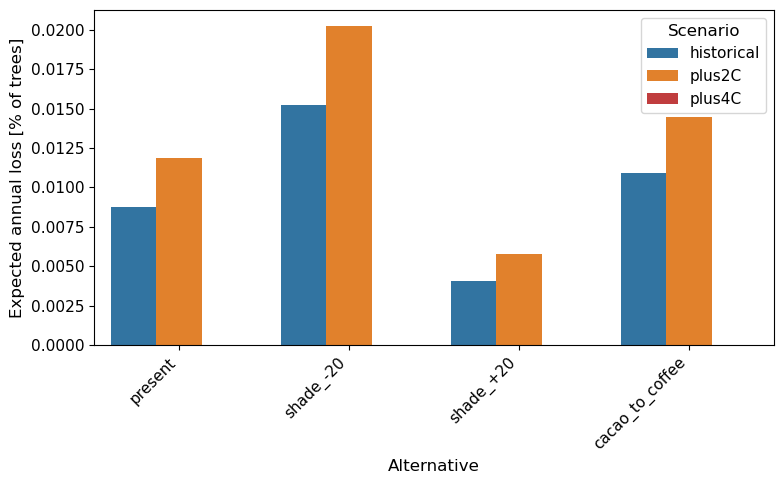

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Cacao__AltaVerapaz_TC_barplot.png


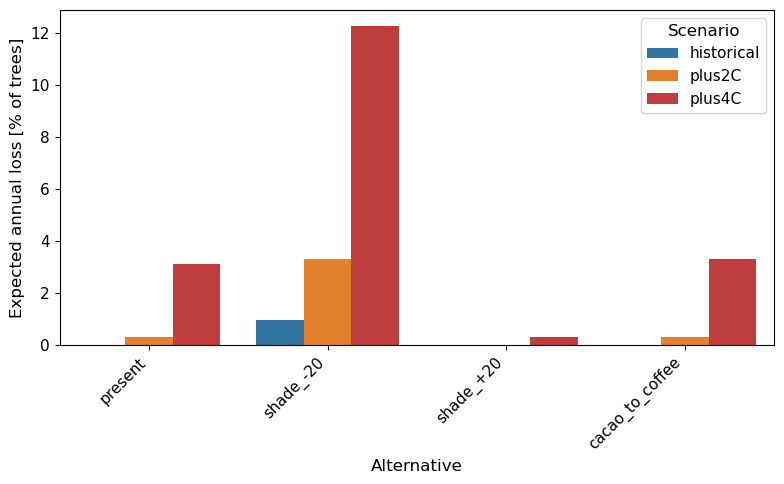

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Cacao__DR_Cibao_Noroeste_TM_barplot.png


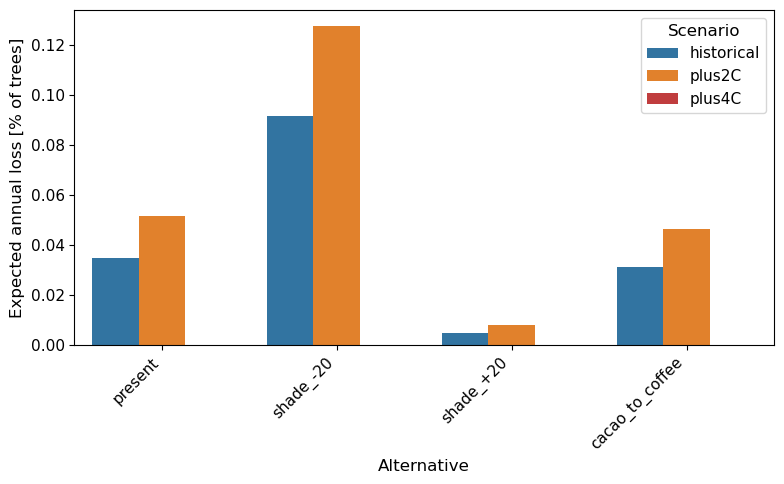

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Cacao__DR_Cibao_Noroeste_TC_barplot.png


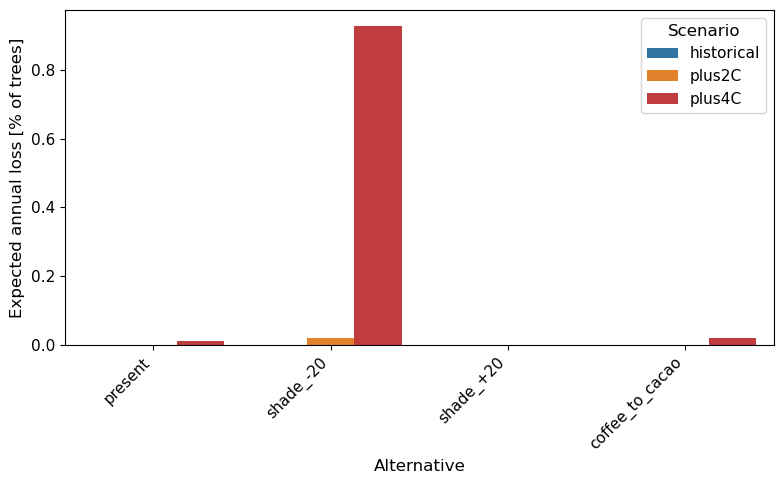

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__DR_Cibao_Noroeste_TM_barplot.png


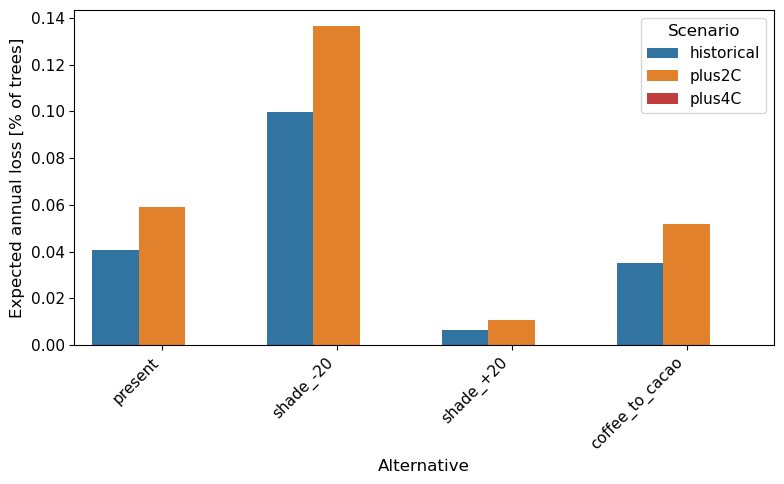

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__DR_Cibao_Noroeste_TC_barplot.png


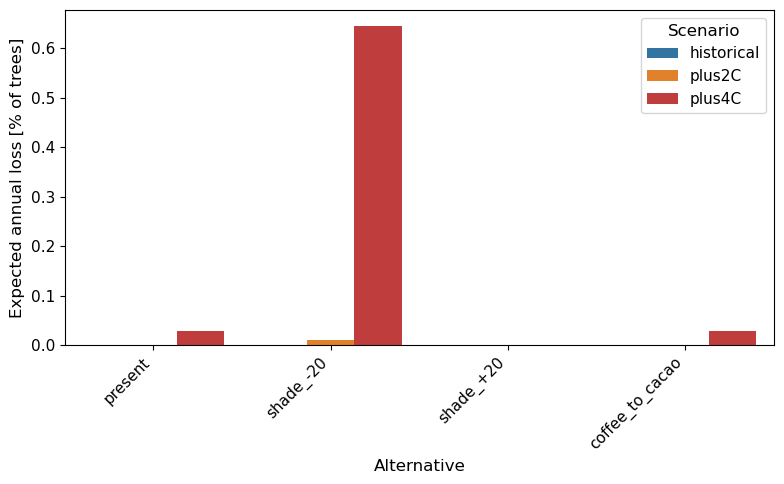

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__Veracruz_TM_barplot.png


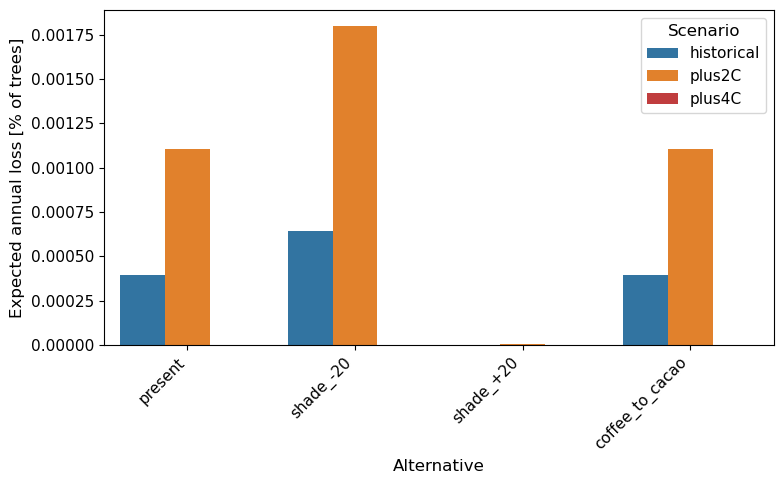

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__Veracruz_TC_barplot.png


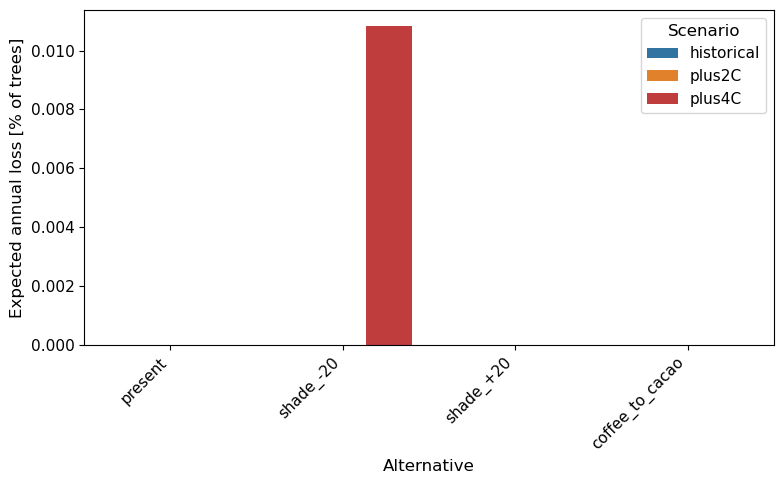

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__WesternHighlands_TM_barplot.png


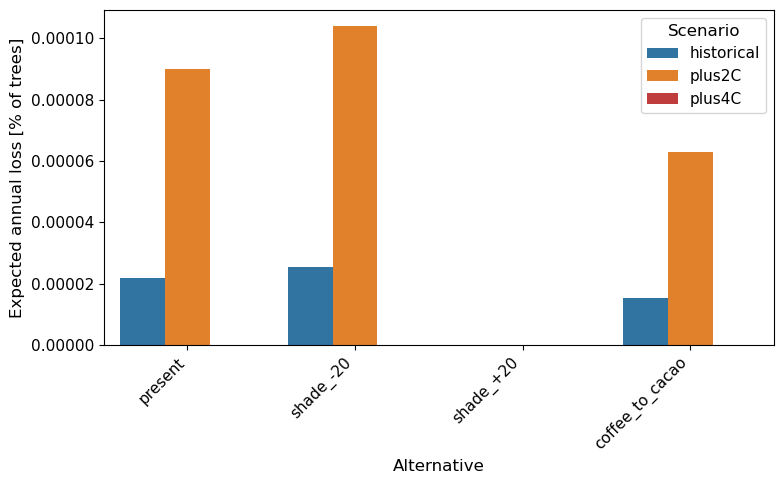

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/barplots/Coffee__WesternHighlands_TC_barplot.png


In [25]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

summary_records = []

# === Build summary dataframe ===
for system_name, alternatives in impact_results.items():
    for alt_name, haz_dict in alternatives.items():
        total_trees = exposures[system_name][alt_name].gdf.value.sum()

        for scenario, hazs in haz_dict.items():
            if scenario not in ["historical", "plus2C", "plus4C"]:  # 🚫 skip +4 °C etc.
                continue
            for haz_code, impact in hazs.items():
                try:
                    eai = impact.aai_agg  # Expected Annual Impact
                    perc_loss = (eai / total_trees) * 100

                    summary_records.append({
                        "System": system_name,
                        "Alternative": alt_name,
                        "Scenario": scenario,
                        "Hazard": haz_code,
                        "PercLoss": perc_loss
                    })
                except Exception as e:
                    print(f"⚠️ Could not compute for {system_name} – {alt_name} – {haz_code}: {e}")
                    continue

df_summary = pd.DataFrame(summary_records)

# === Output directory ===
out_dir = os.path.join(FIGURES_DIR, "barplots")
os.makedirs(out_dir, exist_ok=True)

# === Plot per system × hazard ===
# === Plot per system × hazard (include +4 °C) ===
for system_name in df_summary["System"].unique():
    df_sys = df_summary[df_summary["System"] == system_name]

    for haz_code, haz_label in hazards_to_plot.items():
        df_haz = df_sys[df_sys["Hazard"] == haz_code]

        if df_haz.empty:
            continue

        plt.figure(figsize=(8, 5))
        sns.barplot(
            data=df_haz,
            x="Alternative", y="PercLoss", hue="Scenario",
            hue_order=["historical", "plus2C", "plus4C"],   # ✅ now includes +4 °C
            palette={
                "historical": "tab:blue",
                "plus2C": "tab:orange",
                "plus4C": "tab:red"
            }
        )
        plt.ylabel("Expected annual loss [% of trees]")
        #plt.title(f"{system_name} – {haz_label}")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Scenario")
        plt.tight_layout()

        # Save instead of show
        fname = f"{system_name}_{haz_code}_barplot.png"
        fpath = os.path.join(out_dir, fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"💾 Saved: {fpath}")

In [ ]:
df_summary

## Multi-panel barplots of expected annual loss

This script creates **facet barplots** to compare expected annual losses across systems and hazards:

1. Map hazard codes (`DR`, `TM`, `TC`) to descriptive labels.  
2. Build a clean dataframe (`df_plot`) with only valid hazard entries.  
3. Plot barplots with Seaborn:  
   - One panel per hazard (`col="Hazard"`).  
   - X-axis = system, Y-axis = % trees lost.  
   - Hue = scenario (`historical` vs `plus2C`).  
4. Save combined figure as `system_comparison_barplot_extremes.png` in `FIGURES_DIR/barplots/`.

📌 Useful for side-by-side comparison of how different systems and hazards respond to climate scenarios.  


Unique hazard codes in df_summary: ['TM' 'TC']


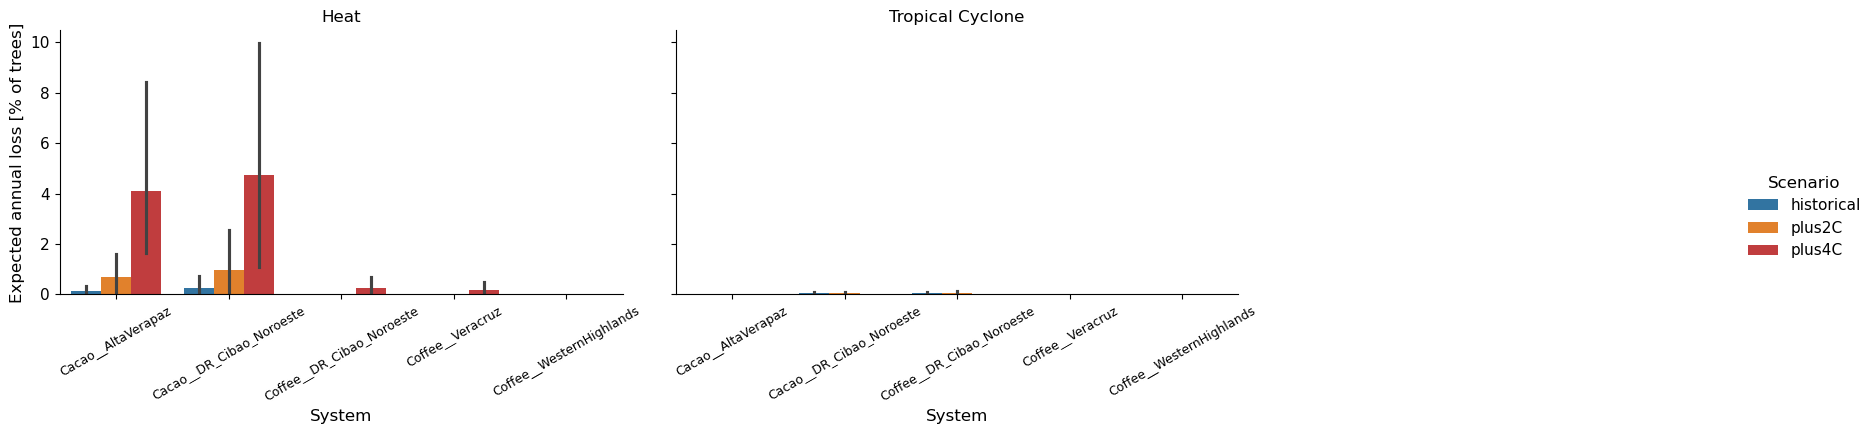

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


# === Output directory ===
out_dir = os.path.join(FIGURES_DIR, "barplots")
os.makedirs(out_dir, exist_ok=True)

# Inspect hazard codes in df_summary
print("Unique hazard codes in df_summary:", df_summary["Hazard"].unique())

# Replace codes with labels, keep unmapped as-is
df_summary["Hazard"] = df_summary["Hazard"].replace(hazards_to_plot)

# Drop any rows where Hazard is still missing
df_plot = df_summary.dropna(subset=["Hazard"]).copy()

# === Plot: one panel per hazard (include +4 °C) ===
g = sns.catplot(
    data=df_plot,
    x="System", y="PercLoss",
    hue="Scenario", col="Hazard",
    kind="bar",
    hue_order=["historical", "plus2C", "plus4C"],   # ✅ add +4 °C
    palette={
        "historical": "tab:blue",
        "plus2C": "tab:orange",
        "plus4C": "tab:red"
    },
    dodge=True,
    col_wrap=3, height=4.5, aspect=1.3
)

g.set_titles("{col_name}")
g.set_axis_labels("System", "Expected annual loss [% of trees]")

# Rotate x-axis labels for readability
for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=30, labelsize=9)

plt.tight_layout()

fname = f"system_comparison_barplot_extremes.png"
fpath = os.path.join(out_dir, fname)
plt.savefig(fpath, dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
for alt_name, exp in exposures[system_name].items():
    counts = exp.gdf[["impf_TM"]].value_counts().sort_index()
    print(f"{alt_name}:\n{counts}\n")
